### Implementing AlexNet

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

import torchvision.datasets as dset
import torchvision.transforms as T

from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import Dataset

from tensorboardX import SummaryWriter

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

dtype = torch.float32

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [2]:
OUTPUT_DIR = 'alexnet_data_out'
LOG_DIR = OUTPUT_DIR + '_' + 'tensor_board_logs'

### After some default settings and importings, we also need to define some functions to preprocess the data from CIFAR-10 and define the pytorch dataloaders as iterators.

In [3]:
NUM_TRAIN = 49000
transform = T.Compose([
    T.Resize((227, 227)),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
def get_train_val_test_loader(data_dir='./datasets',
                        batch_size=128,
                        transform=transform):
    cifar10_train = dset.CIFAR10(root=data_dir,
                                 download=True,
                                 train=True,
                                 transform=transform)
    cifar10_test = dset.CIFAR10(root=data_dir,
                                download=True,
                                train=False,
                                transform=transform)
    cifar10_val = dset.CIFAR10(root=data_dir,
                               download=True,
                               train=True,
                               transform=transform)

    loader_train = DataLoader(cifar10_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
    loader_val = DataLoader(cifar10_val, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
    loader_test = DataLoader(cifar10_test, batch_size=batch_size)
    return loader_train, loader_val, loader_test, cifar10_train, cifar10_val, cifar10_test

loader_train, loader_val, loader_test, cifar10_train, cifar10_val, cifar10_test  = get_train_val_test_loader()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


**Just for fun and see what actually happened in the above process, let's load a few pictures from our CIFAR-10 training set.**

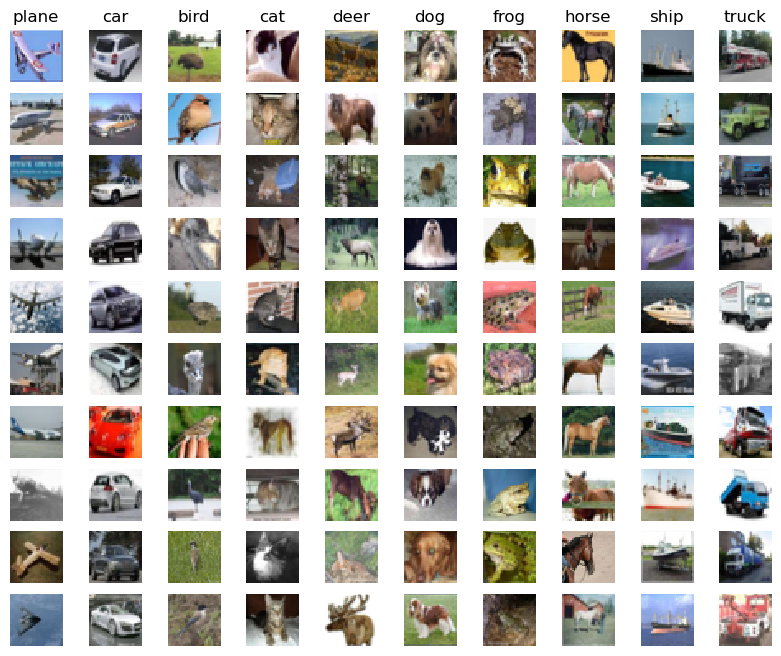

In [4]:

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

cifar10_train.transform = T.Compose([T.ToTensor(), T.Resize((32, 32))])


targets = cifar10_train.targets
num_class = len(classes)
samples_per_class = 10
targets = np.array(cifar10_train.targets)
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y == targets)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        img = cifar10_train[idx][0].permute(1, 2, 0)
        plt.subplot(samples_per_class, num_class, i * num_class + y + 1)
        plt.axis('off')
        plt.imshow(img)
        if i == 0:
            plt.title(cls)
plt.show()
cifar10_train.transform = transform

### OK, let the real work begin!
First, to refer to the original AlexNet paper, here's the link: [AlexNet](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)\
We also need to understand the structure of the AlexNet.\
Now we use PyTorch to implement its structure from the [paper](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N = x.size(0)
        x = x.view(N, -1)
        return x

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.first_conv = nn.Sequential(
                        nn.Conv2d(3, 96, kernel_size=11, stride=4),
                        nn.LocalResponseNorm(size=5, k=2),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3, stride=2)
                        )
        self.second_conv = nn.Sequential(
                         nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
                         nn.LocalResponseNorm(size=5, k=2),
                         nn.ReLU(),
                         nn.MaxPool2d(kernel_size=3, stride=2)
                         )
        self.third_conv = nn.Sequential(
                        nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
                        nn.ReLU()
                        )
        self.fourth_conv = nn.Sequential(
                         nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
                         nn.ReLU()
                         )
        self.fifth_conv = nn.Sequential(
                        nn.Conv2d(384, 256, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3, stride=2)
                        )
        
        self.classifier = nn.Sequential(
                        Flatten(),
                        nn.Dropout(),
                        nn.Linear(256 * 6 * 6, 4096),
                        nn.ReLU(),
                        nn.Dropout(),
                        nn.Linear(4096, 4096),
                        nn.ReLU(),
                        nn.Linear(4096, 10)
                        )
        self.alexnet = nn.Sequential(
                     self.first_conv,
                     self.second_conv,
                     self.third_conv,
                     self.fourth_conv,
                     self.fifth_conv,
                     self.classifier
                     )
        self.init_bias()

    def init_bias(self):
        for layer in self.alexnet:
            for structure in layer:
                if isinstance(structure, nn.Conv2d):
                    nn.init.normal_(structure.weight, mean=0, std=0.01)
                    nn.init.constant_(structure.bias, 0)
        nn.init.constant_(self.second_conv[0].bias, 1)
        nn.init.constant_(self.fourth_conv[0].bias, 1)
        nn.init.constant_(self.fifth_conv[0].bias, 1)

    def forward(self, x):
        return self.alexnet(x)



In [6]:
def check_accuracy(model, loader):
    if loader.dataset.train:
        print("Checking accuracy on validation set")
    else:
        print("Checking accuracy on test set")

    num_correct = 0
    num_samples = 0

    model.eval()    # Set the model to validation mode
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            
            score = model(x)

            _, y_pred = score.max(1)
            num_correct += (y_pred == y).sum()
            num_samples += y.size(0)

        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print()

In [7]:
seed = torch.initial_seed()
print(f"Used seed:{seed}")

tb_writer = SummaryWriter(log_dir=LOG_DIR)
print("Tensorboard Summary Writer created")

alexnet = AlexNet(num_classes=10).to(device=device)
print(f"alexnet : {alexnet} created")

optimizer = optim.Adam(alexnet.parameters(), lr=0.0001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
print(f"optimizer: {optimizer} created")

Used seed:75837155435900
Tensorboard Summary Writer created
alexnet : AlexNet(
  (first_conv): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (second_conv): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (third_conv): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (fourth_conv): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (fifth_conv): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_si

In [8]:
def train_alexnet(model, optimizer, epochs, print_every=80):
    model = model.to(device=device)

    total_steps = 0
    for e in range(epochs):
        for i, (x, y) in enumerate(loader_train):

            model.train()
            
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            
            score = model(x)
            
            loss = F.cross_entropy(score, y)
            
            optimizer.zero_grad()

            loss.backward()
            
            optimizer.step()
            
        
            if total_steps % print_every == 0:
                with torch.no_grad():
                    _, y_pred = score.max(1)
                    acc = torch.sum(y_pred == y) / y.size(0)
                    print(f"Epochs {e}, loss = {loss.item()}, step = {total_steps}, accuracy = {acc * 100}%")
                    tb_writer.add_scalar('loss', loss.item(), total_steps)
                    tb_writer.add_scalar('accuracy', acc.item(), total_steps)
            
            if total_steps % 100 == 0:
                with torch.no_grad():
                    print('*' * 10)
                    for name, parameter in model.named_parameters():
                        if parameter.grad is not None:
                            avg_grad = torch.mean(parameter.grad)
                            print('\t{} - grad_avg: {}'.format(name, avg_grad))
                            tb_writer.add_scalar('grad_avg/{}'.format(name), avg_grad.item(), total_steps)
                            tb_writer.add_histogram('grad/{}'.format(name), parameter.grad.cpu().numpy(), total_steps)
                        
                        if parameter.data is not None:
                            avg_weight = torch.mean(parameter.data)
                            print('\t{} - param_avg: {}'.format(name, avg_weight))
                            tb_writer.add_histogram('weight/{}'.format(name),parameter.data.cpu().numpy(), total_steps)
                            tb_writer.add_scalar('weight_avg/{}'.format(name), avg_weight.item(), total_steps)
            
            total_steps += 1



In [9]:
train_alexnet(alexnet, optimizer, epochs=40, print_every=128)

Epochs 0, loss = 2.306222677230835, step = 0, accuracy = 17.1875%
**********
	first_conv.0.weight - grad_avg: 2.548574002503301e-06
	first_conv.0.weight - param_avg: -3.1792413210496306e-05
	first_conv.0.bias - grad_avg: 1.8106793504557572e-06
	first_conv.0.bias - param_avg: -2.6076927497342695e-06
	second_conv.0.weight - grad_avg: 2.4063048442712898e-08
	second_conv.0.weight - param_avg: -2.2050959159969352e-05
	second_conv.0.bias - grad_avg: 1.5496368632739177e-06
	second_conv.0.bias - param_avg: 1.0000022649765015
	third_conv.0.weight - grad_avg: -8.49535410907265e-08
	third_conv.0.weight - param_avg: -2.60439696830872e-06
	third_conv.0.bias - grad_avg: 4.688751573667105e-07
	third_conv.0.bias - param_avg: -3.370526883372804e-06
	fourth_conv.0.weight - grad_avg: 9.35776995447668e-07
	fourth_conv.0.weight - param_avg: 1.0443756764288992e-05
	fourth_conv.0.bias - grad_avg: 1.2446051186998375e-05
	fourth_conv.0.bias - param_avg: 0.999995231628418
	fifth_conv.0.weight - grad_avg: 8.5756

### After training, let's test our alexnet and see what happens

In [10]:
def test_accuracy(model, loader):
    if loader.dataset.train:
        print("Checking accuracy on validation set")
    else:
        print("Checking accuracy on test set")

    num_correct = 0
    num_samples = 0
    

    model.eval()    # Set the model to validation mode
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            score = model(x)

            _, y_pred = score.max(1)
            num_correct += (y_pred == y).sum()
            num_samples += y.size(0)
            
            cifar10_test.transform = T.Compose([T.ToTensor(), T.Resize((32, 32))])
            idxs = np.flatnonzero(y_pred.cpu() != y.cpu())
            idxs = np.random.choice(idxs, replace=False)
            img = cifar10_test[idxs][0].permute(1, 2, 0)
            plt.subplot(10, 10, i+1)
            plt.axis('off') 
            plt.title(classes[y_pred[idxs]])
            plt.imshow(img)
            plt.gcf().set_size_inches(15, 15)
            
            cifar10_test.transform = transform
        plt.show()
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print()

        

### Not only do we want to test our model, we also want to know what our model really misclassifies.

Checking accuracy on test set


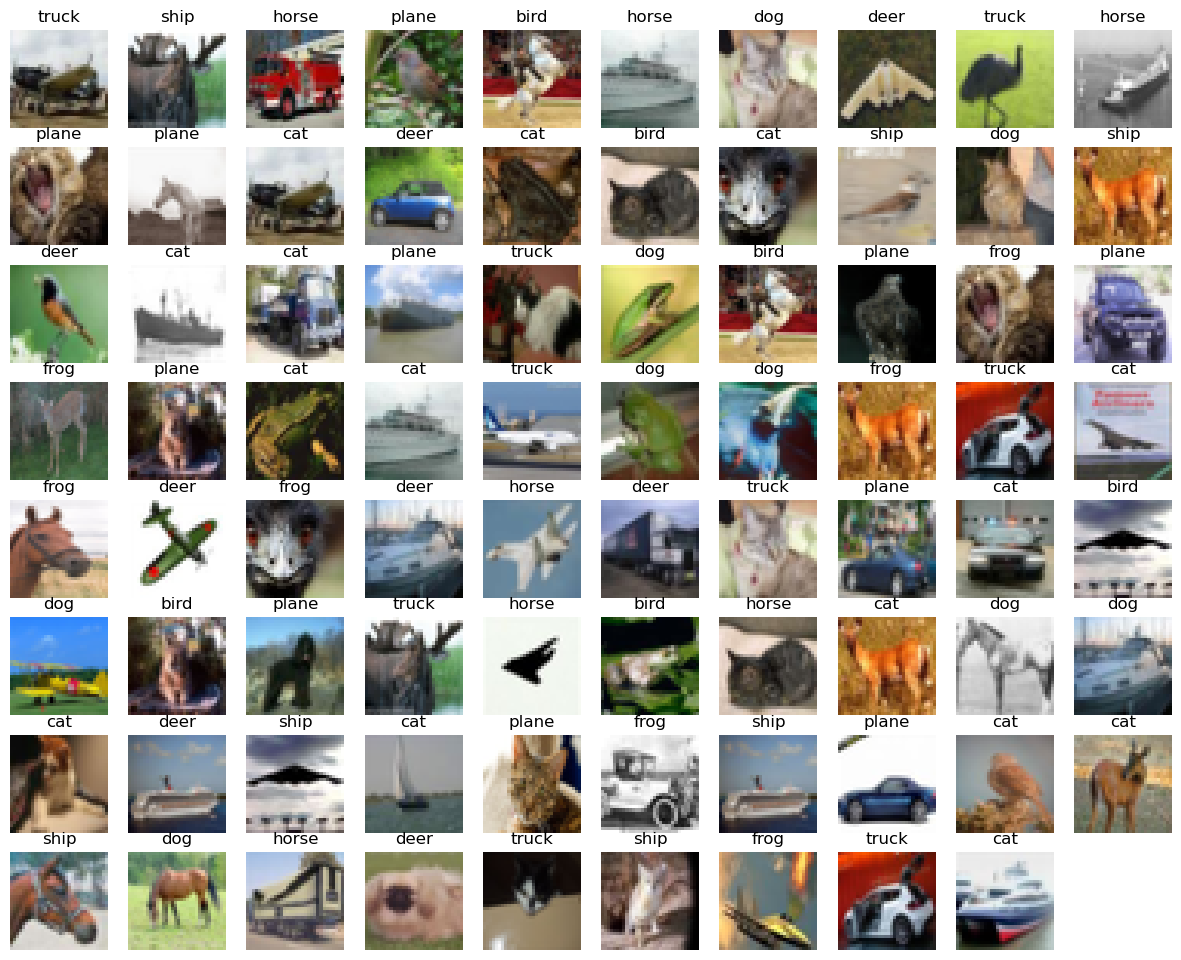

Got 8196 / 10000 correct (81.96)



In [11]:
cifar10_test.transform = transform
test_accuracy(alexnet, loader_test)

Files already downloaded and verified


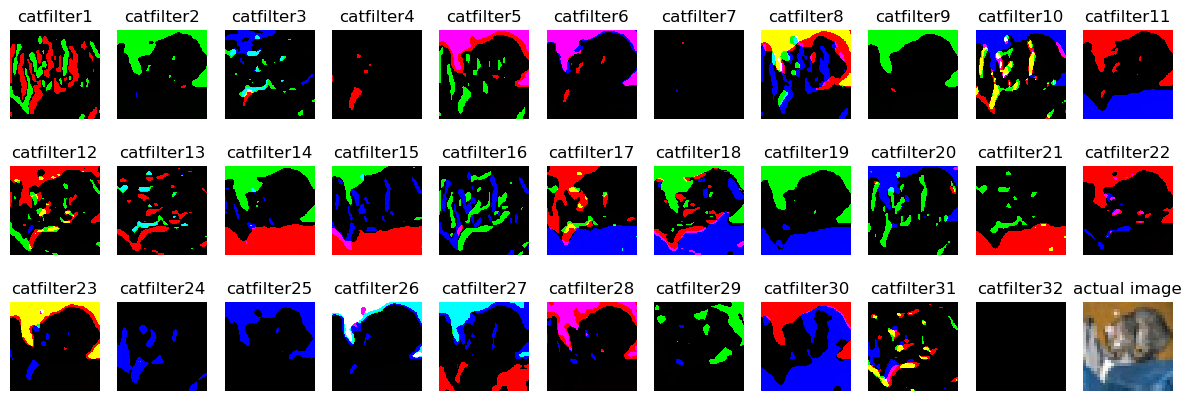

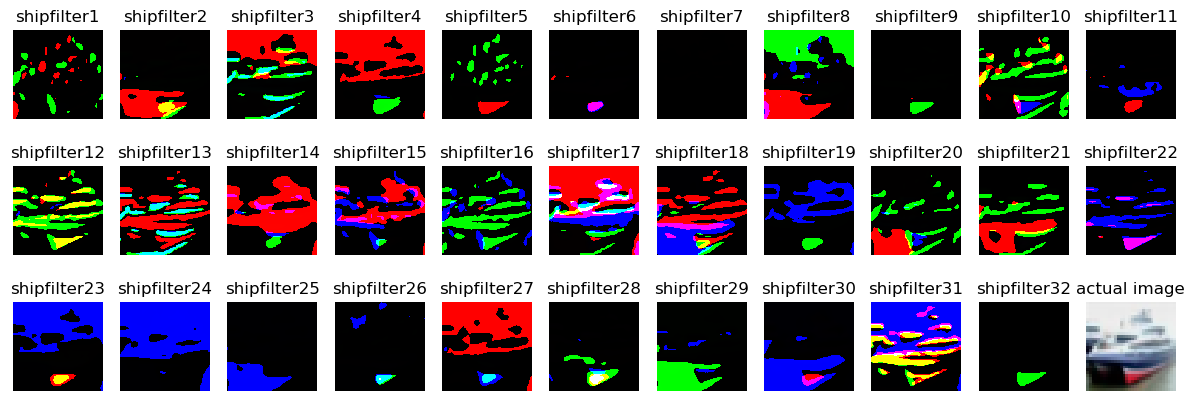

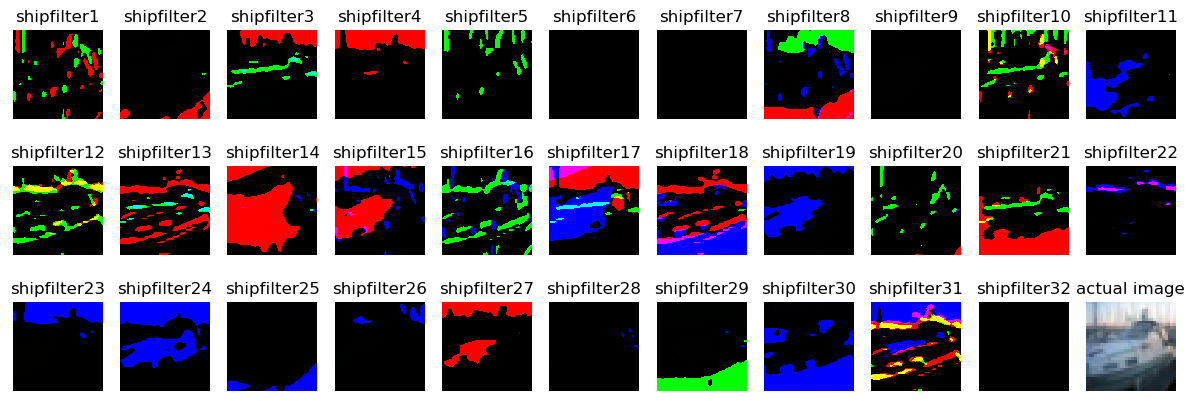

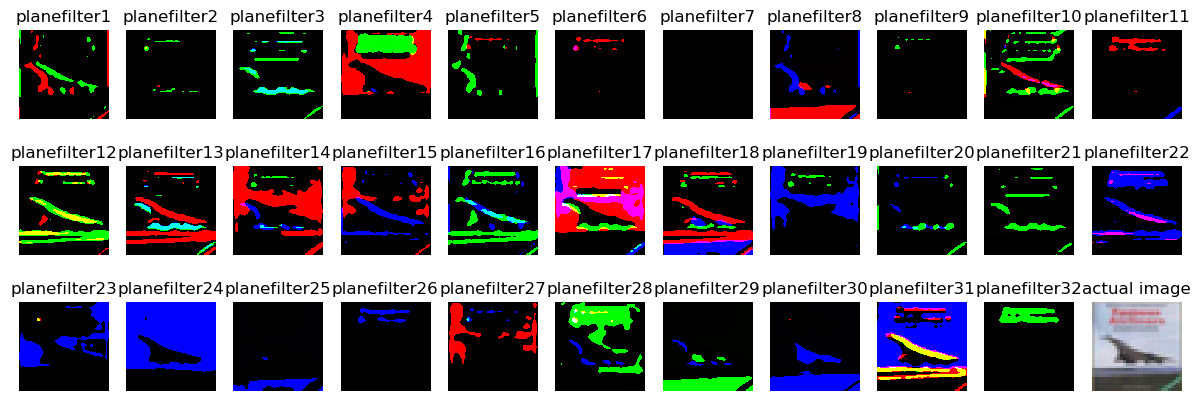

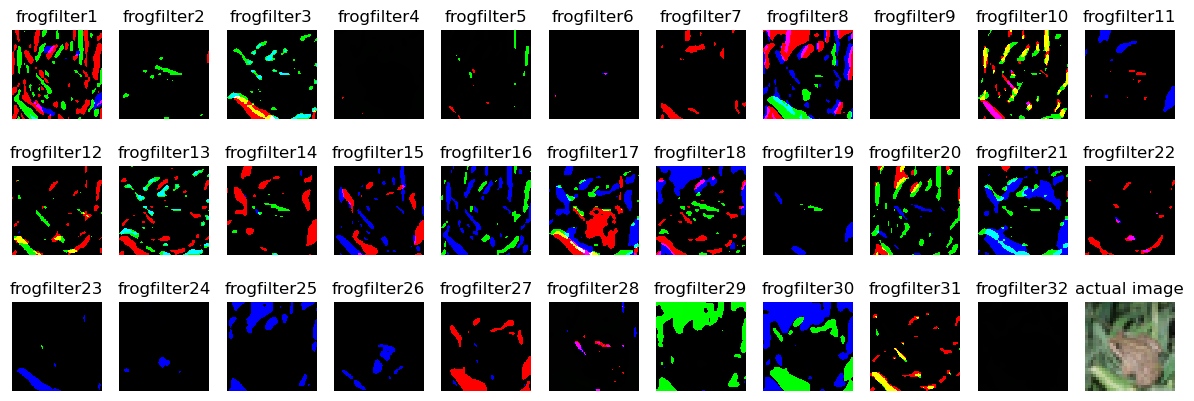

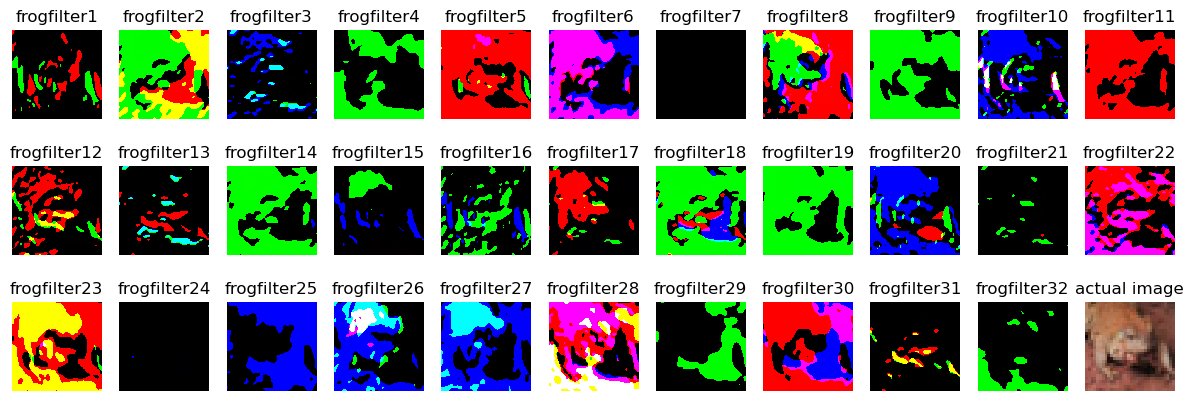

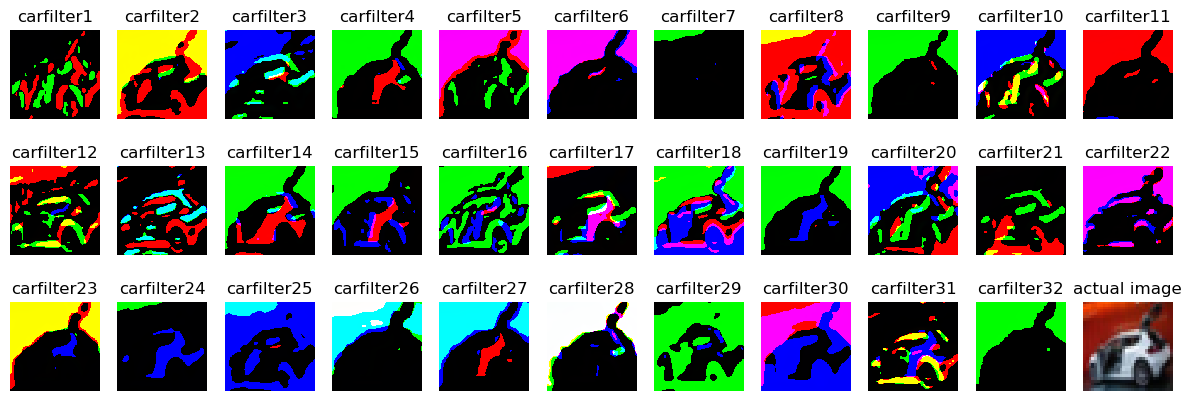

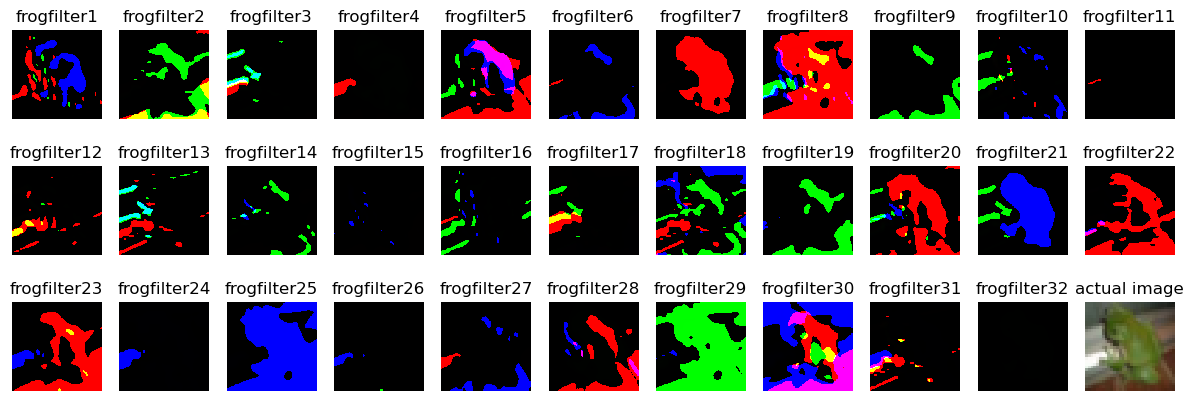

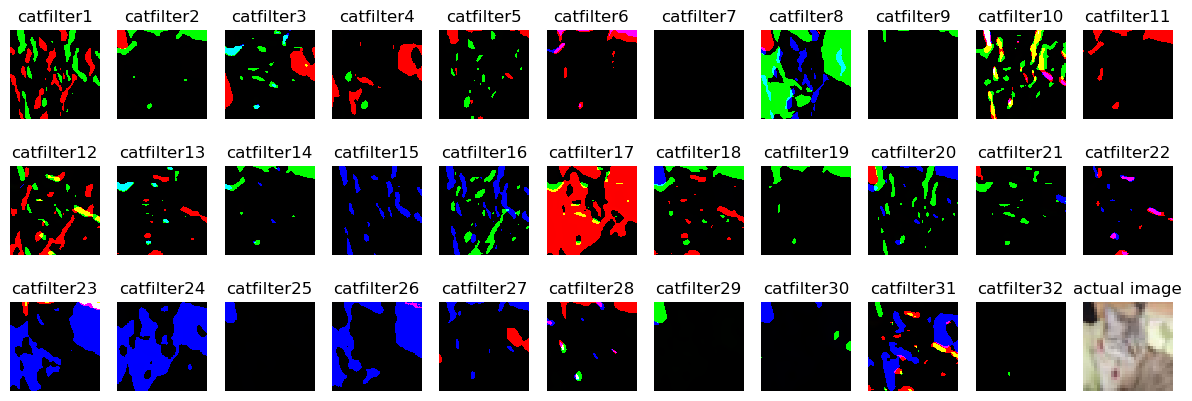

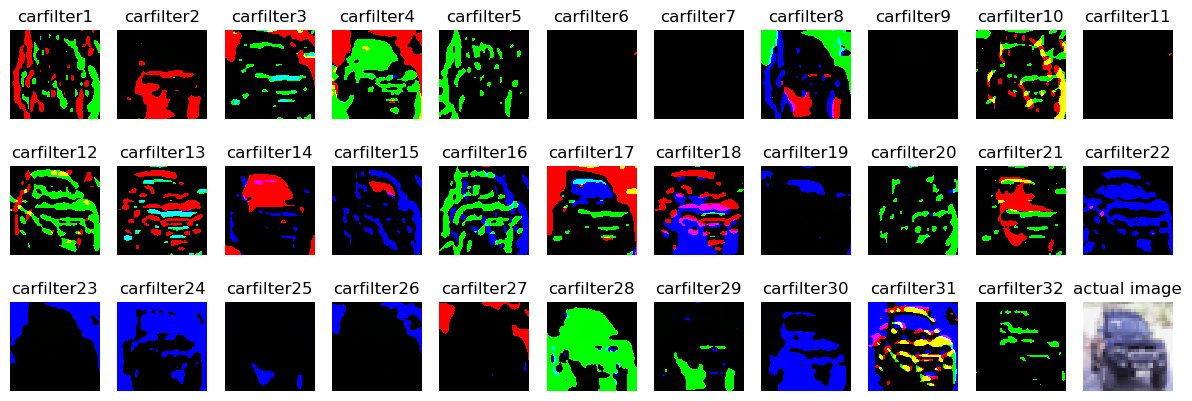

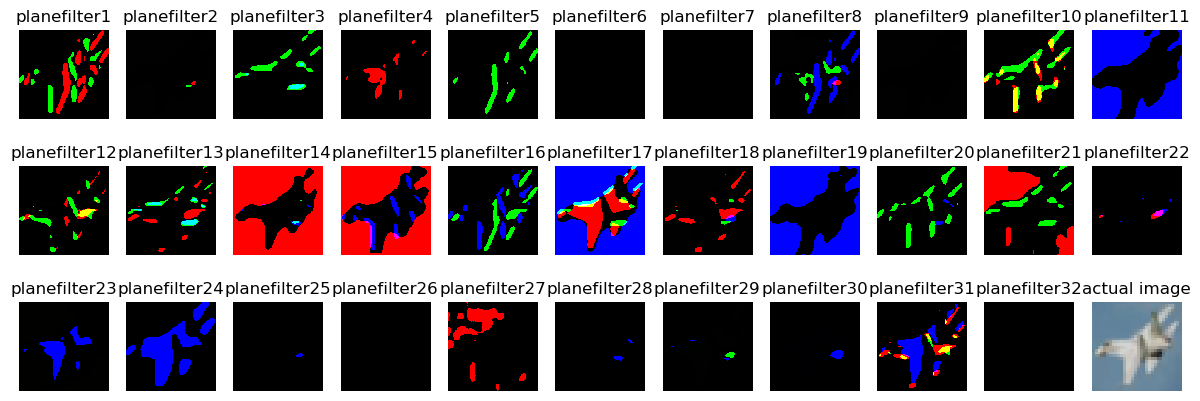

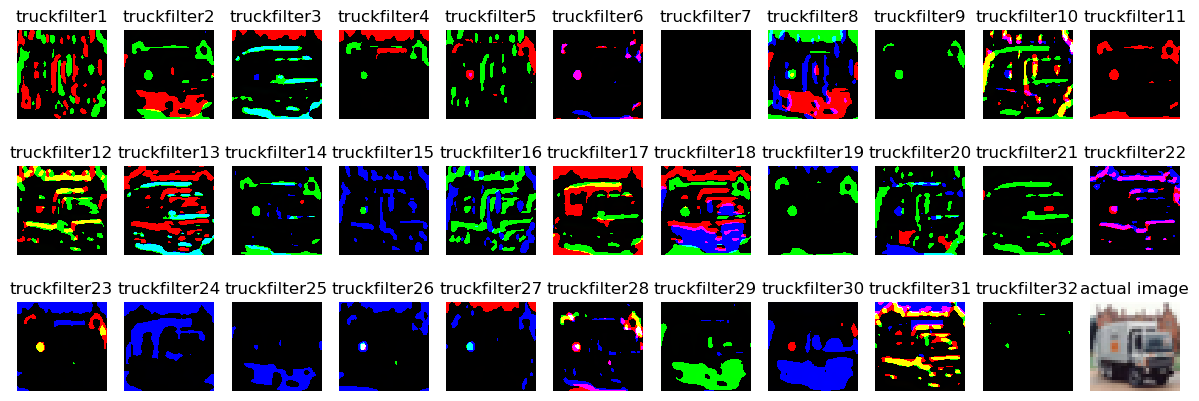

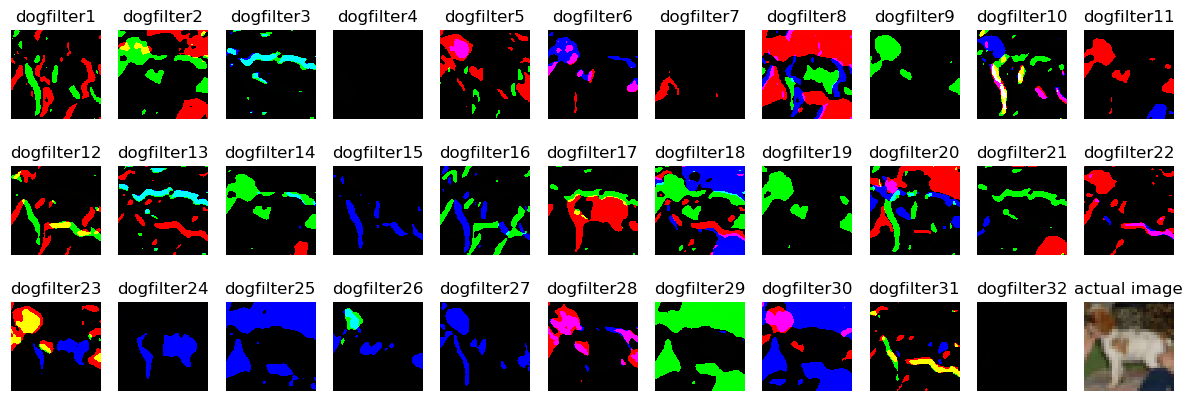

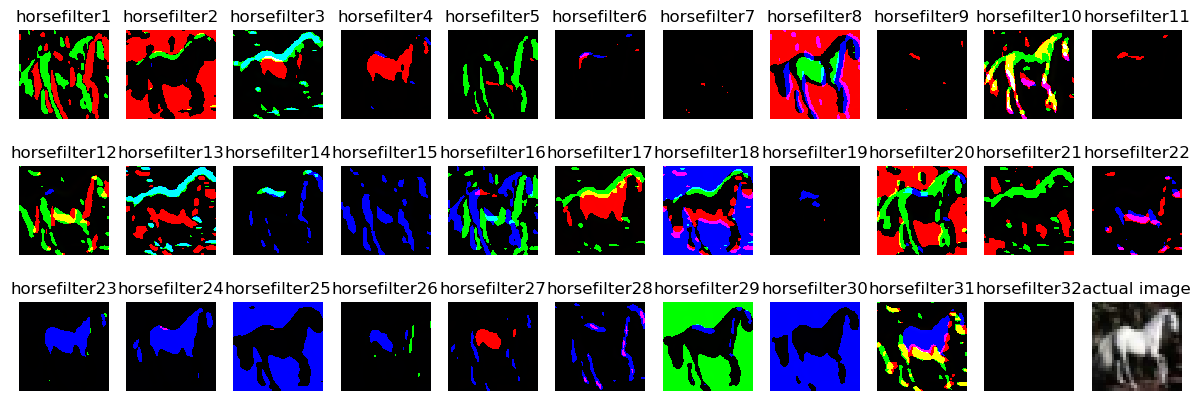

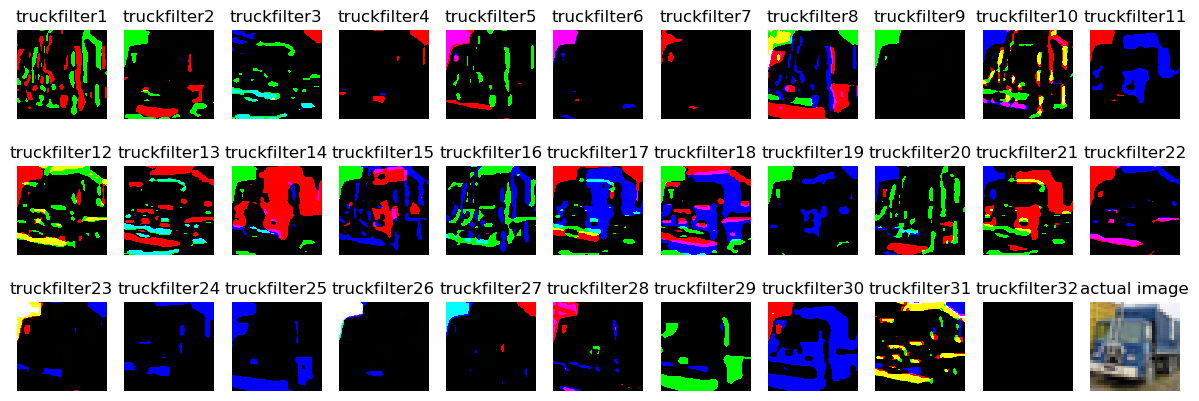

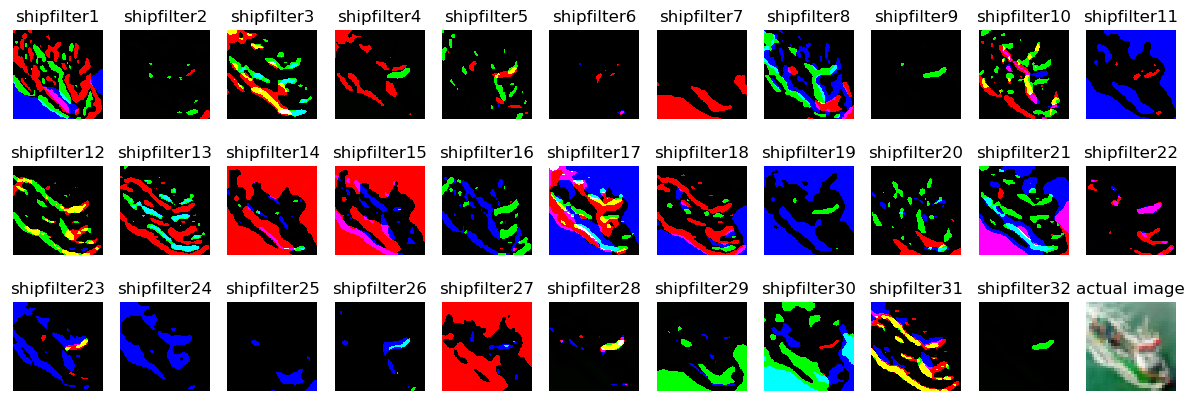

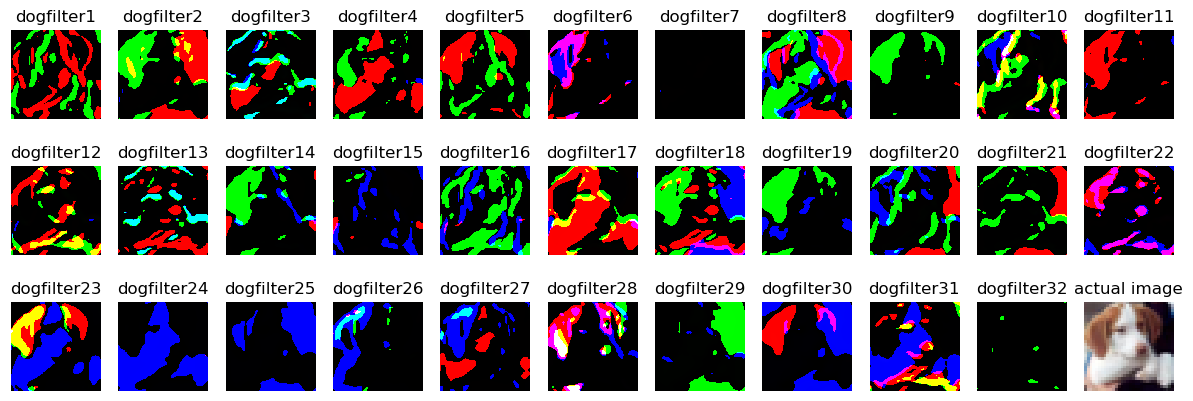

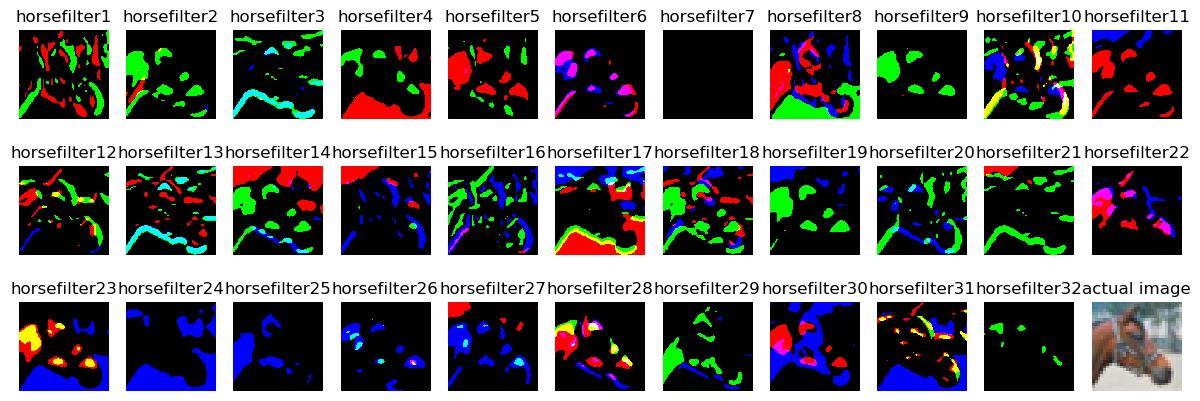

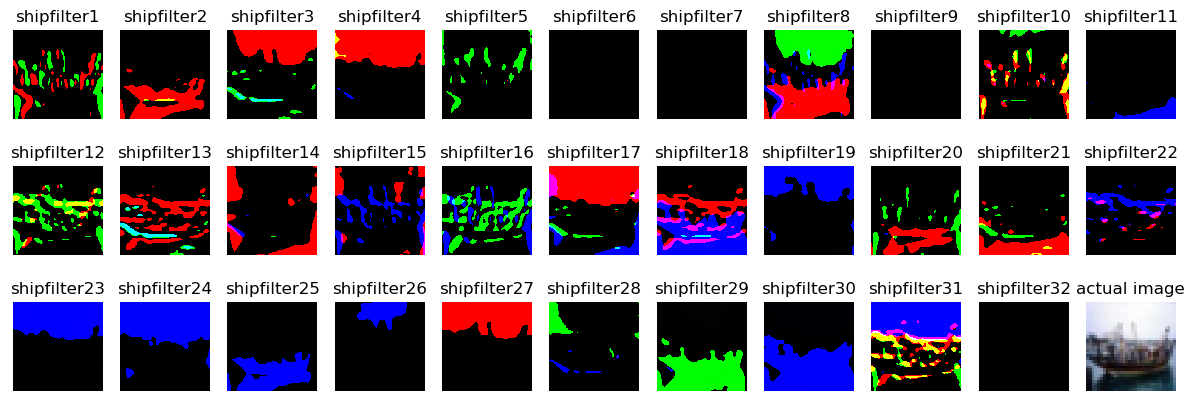

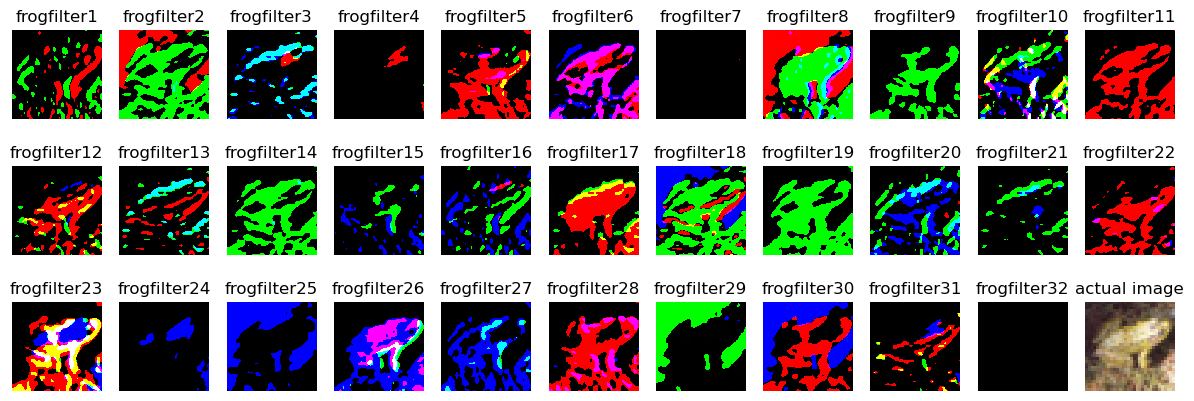

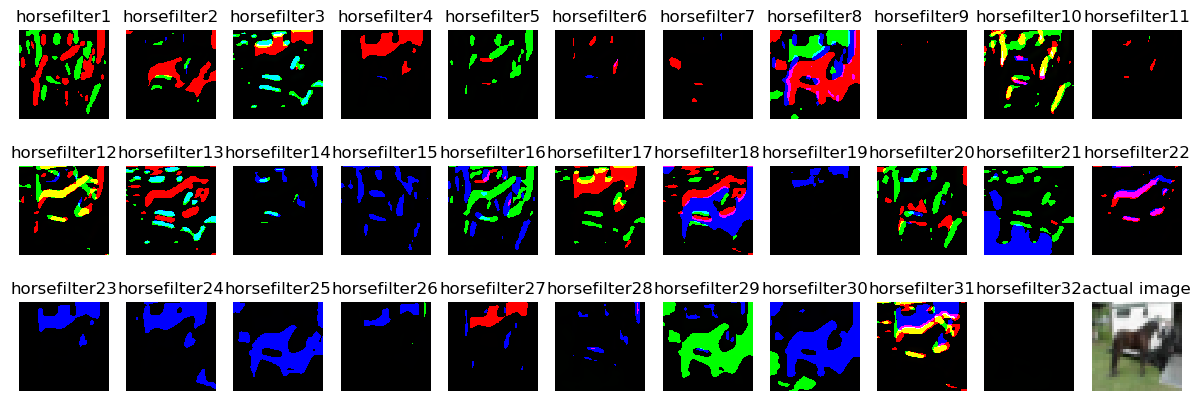

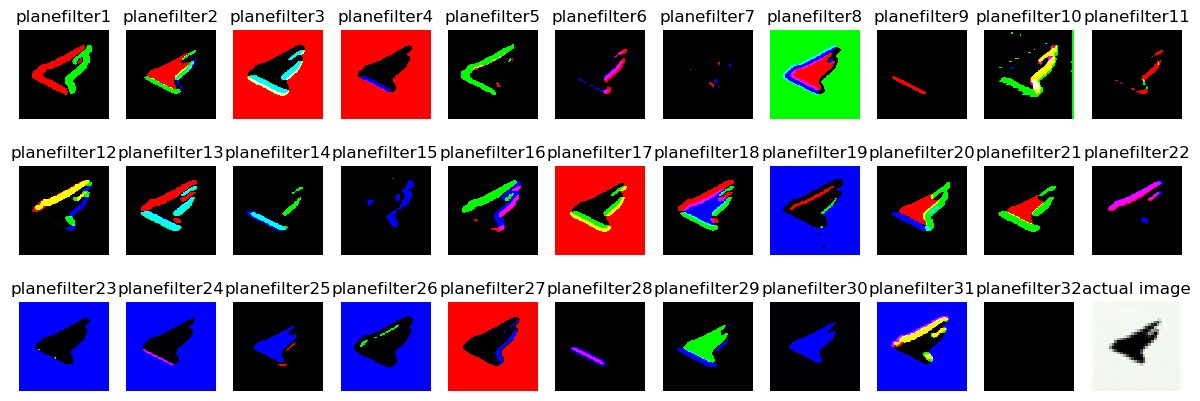

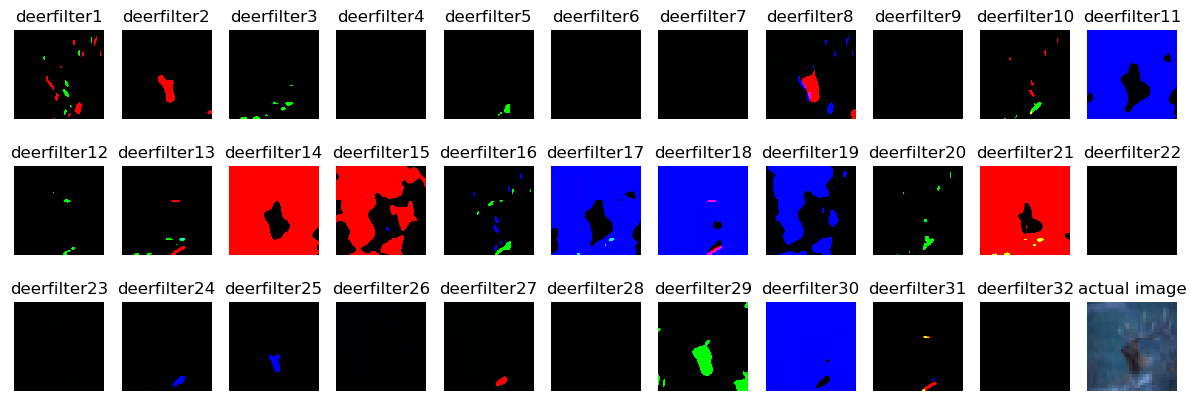

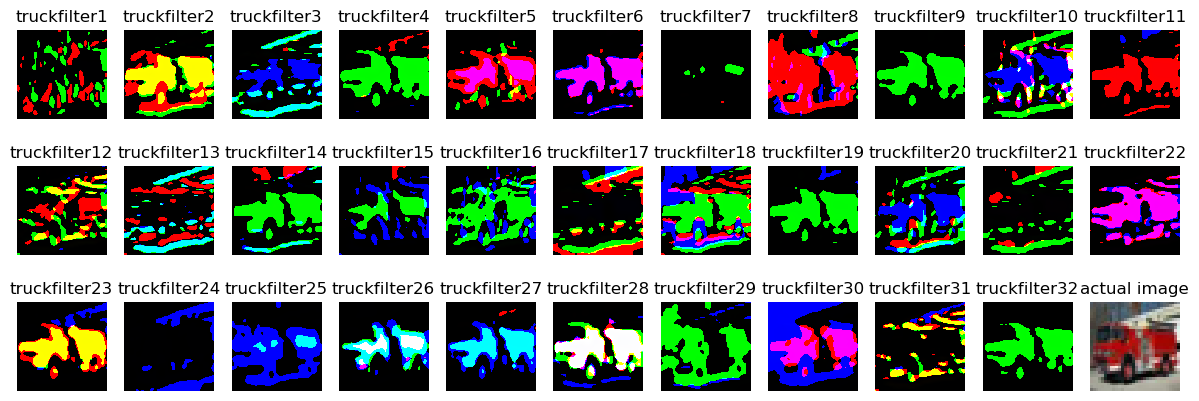

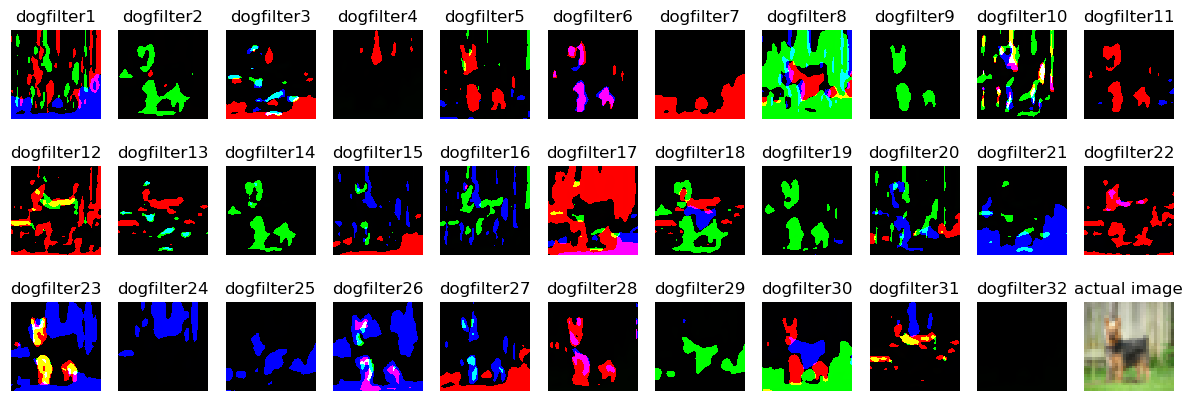

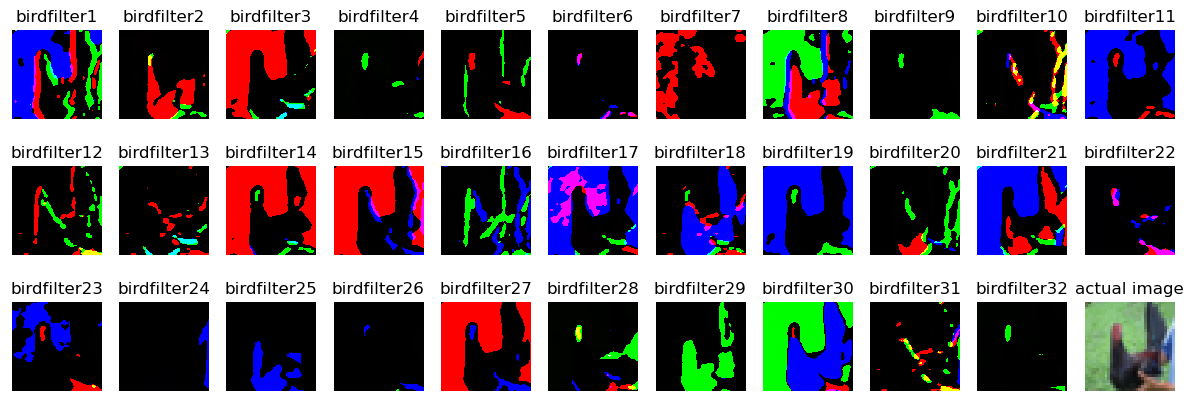

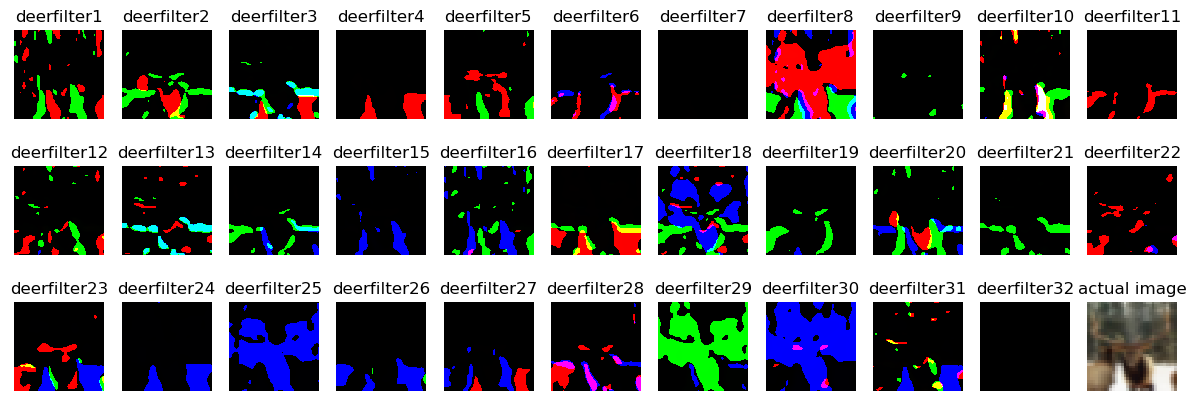

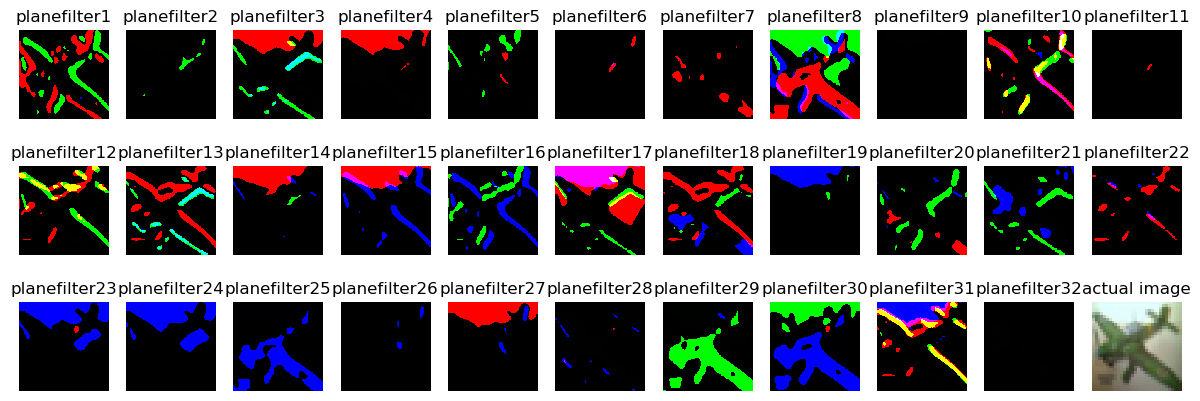

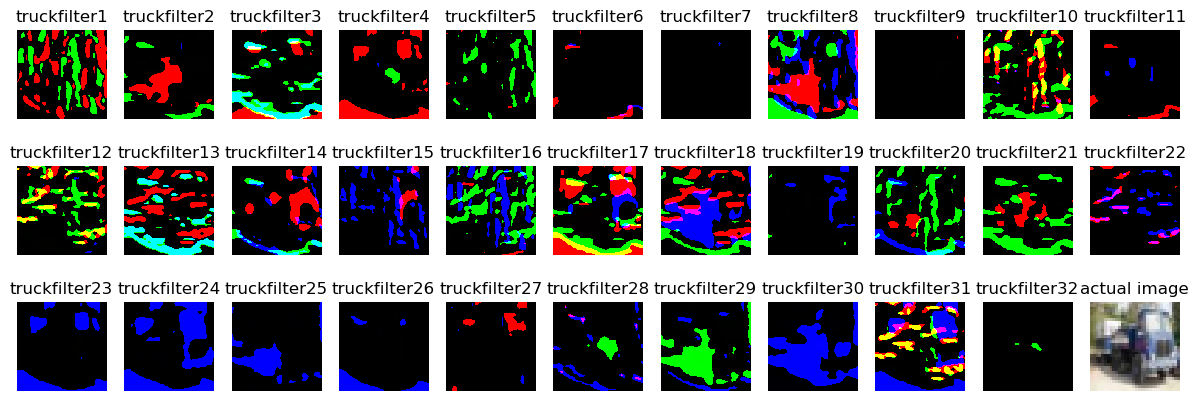

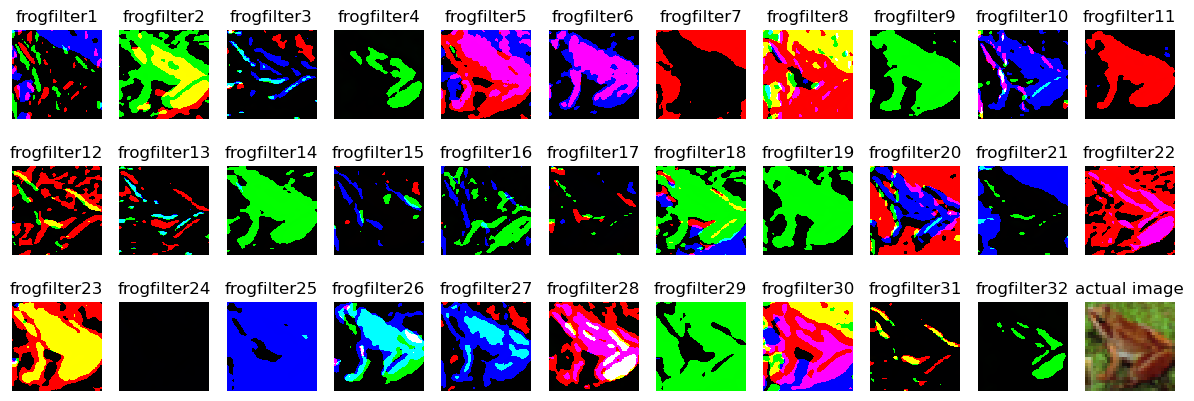

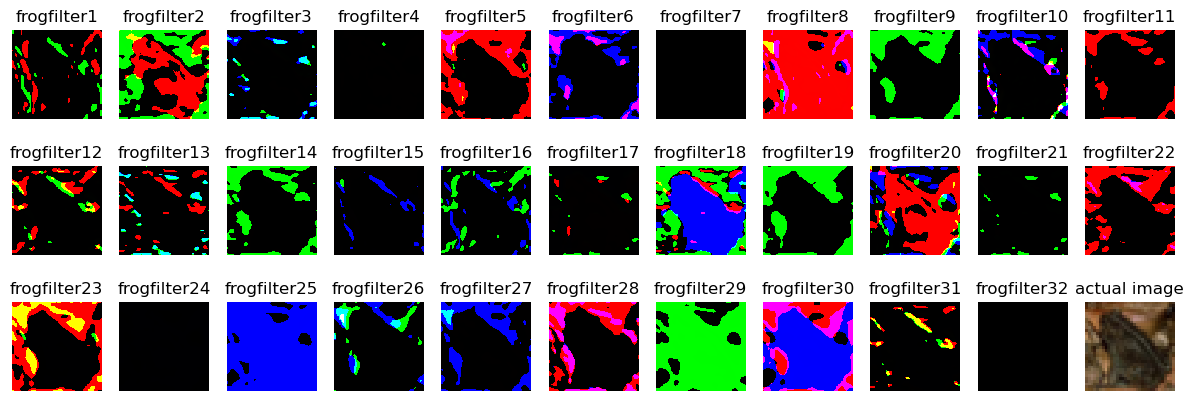

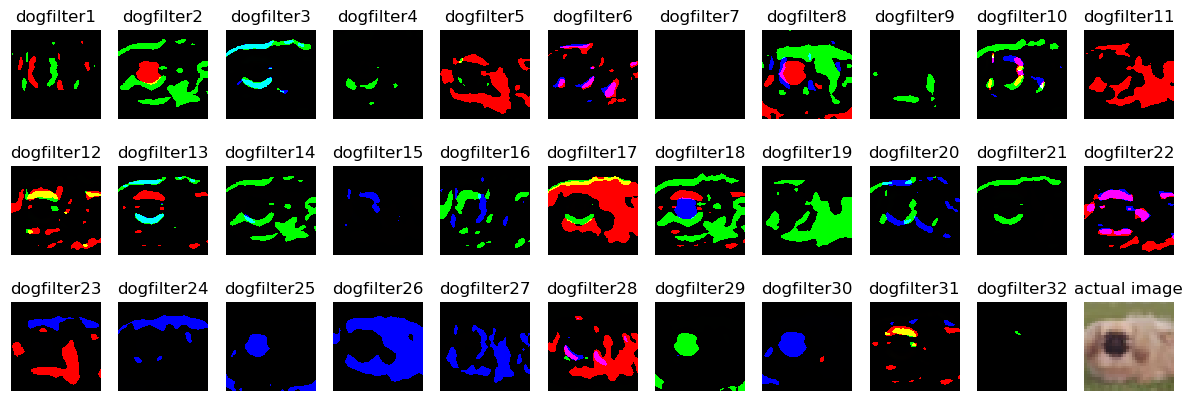

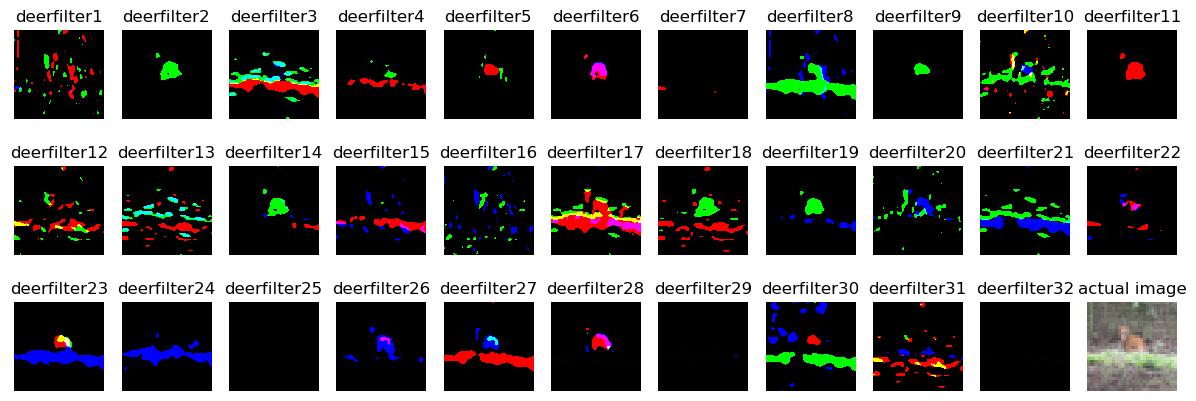

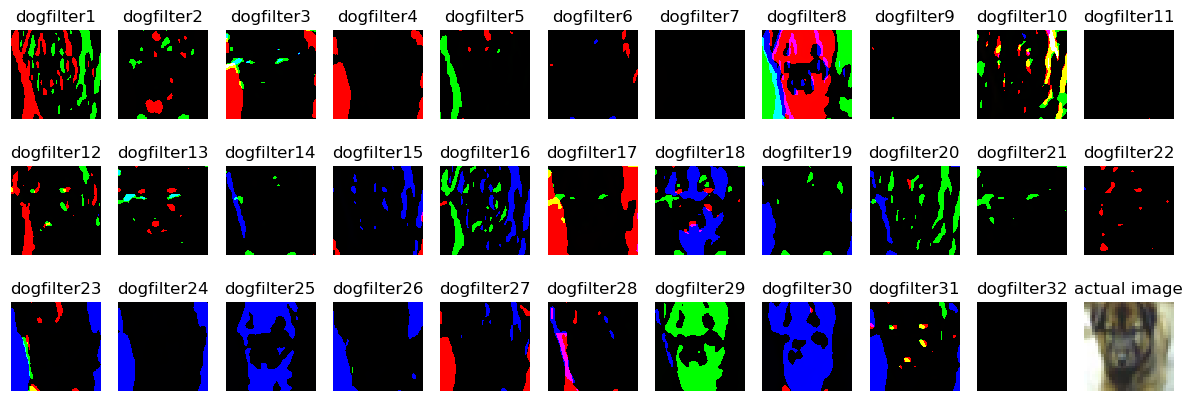

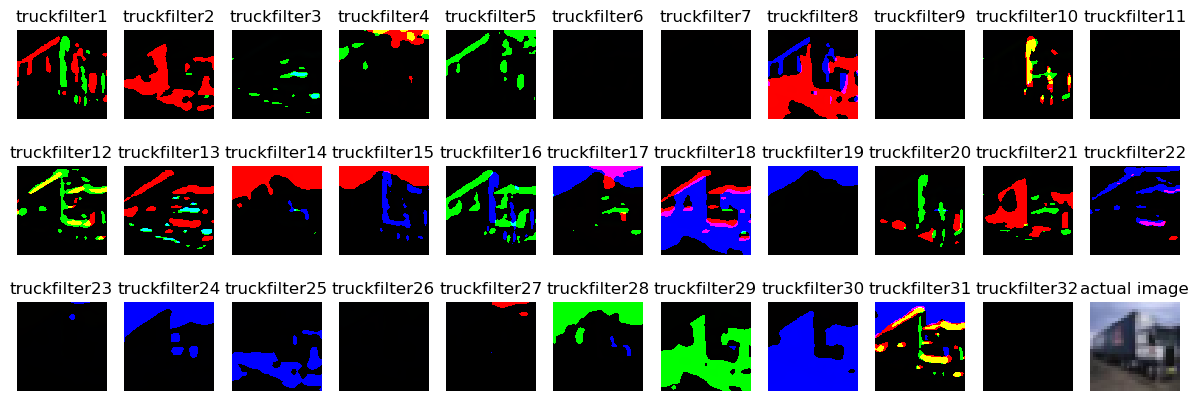

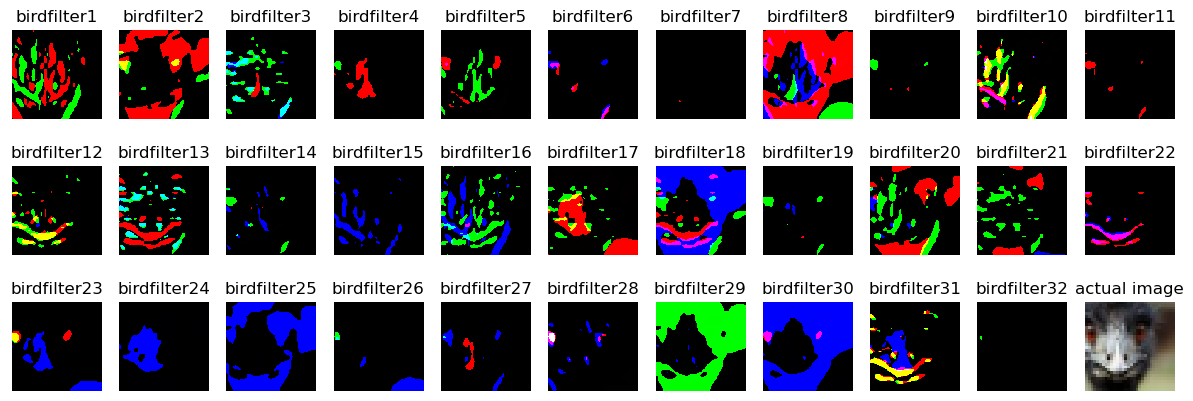

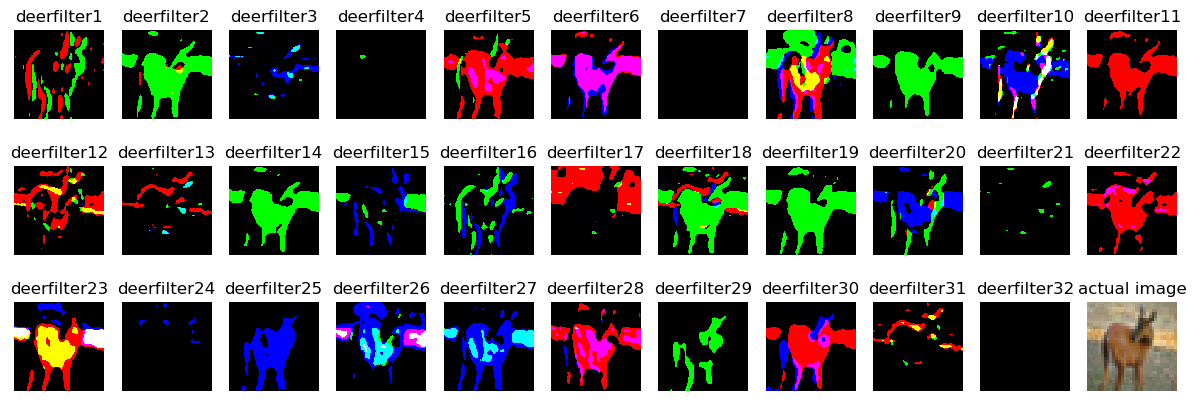

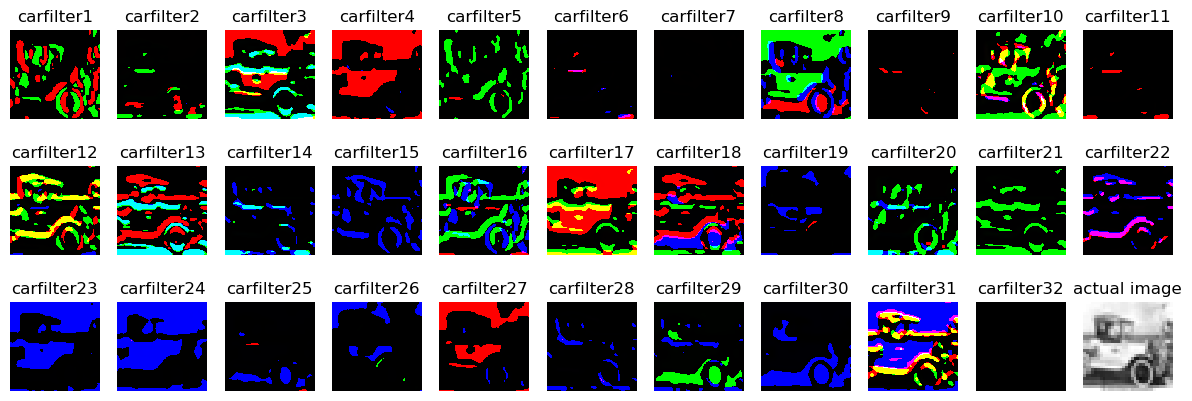

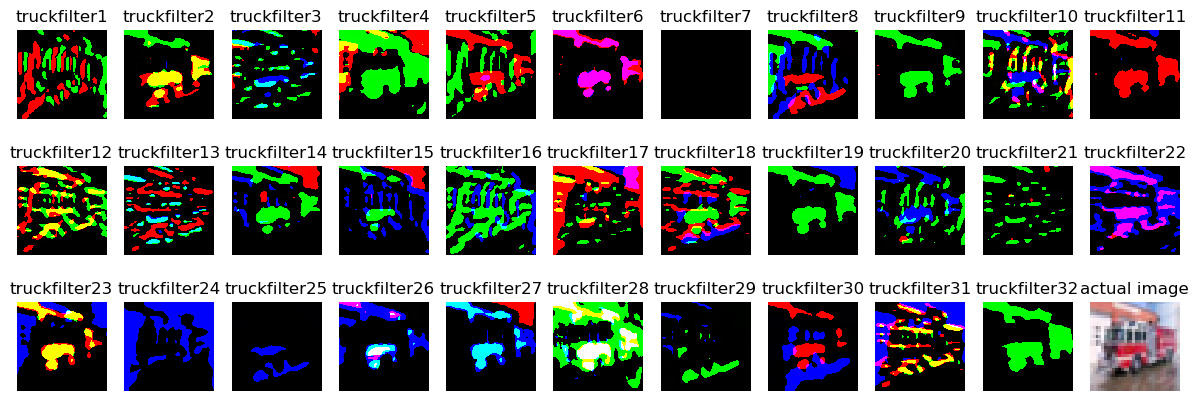

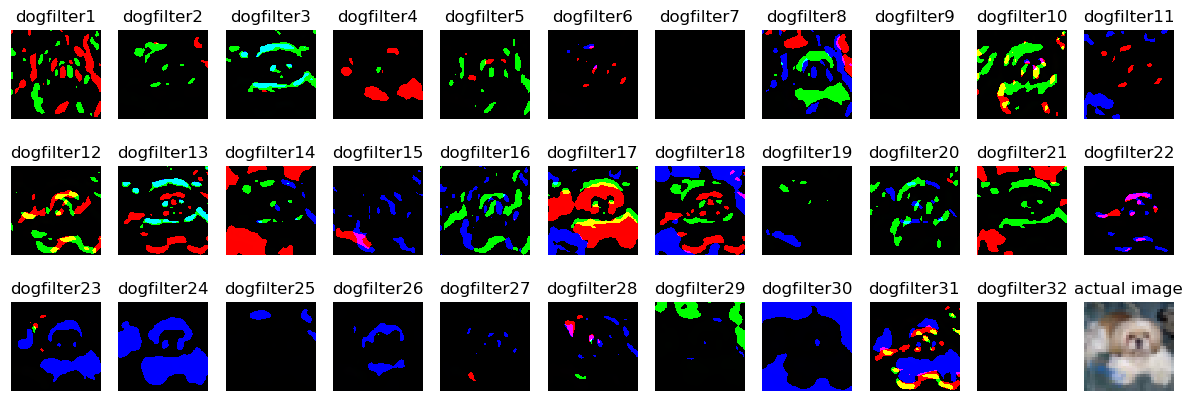

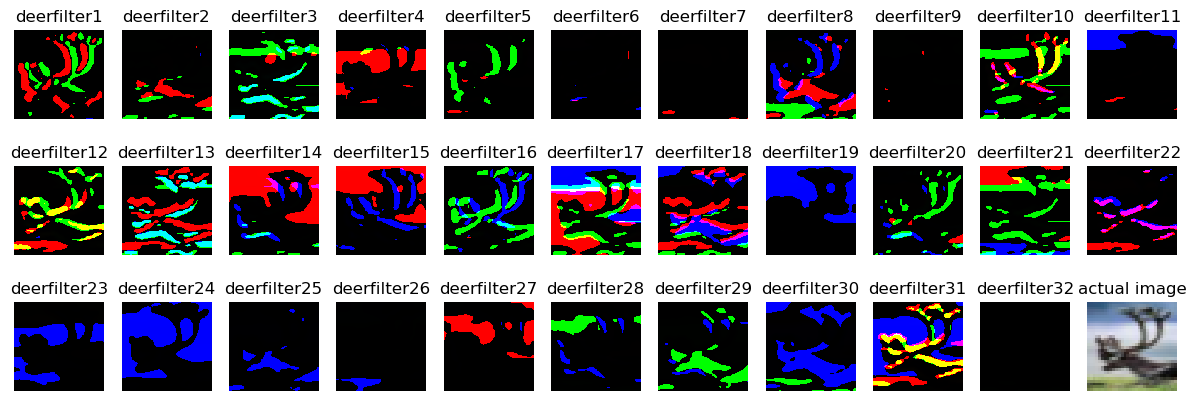

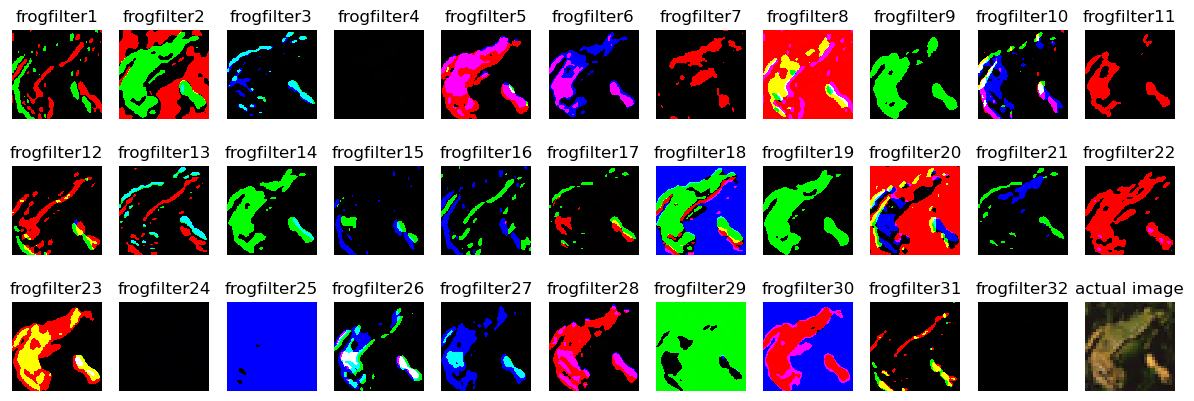

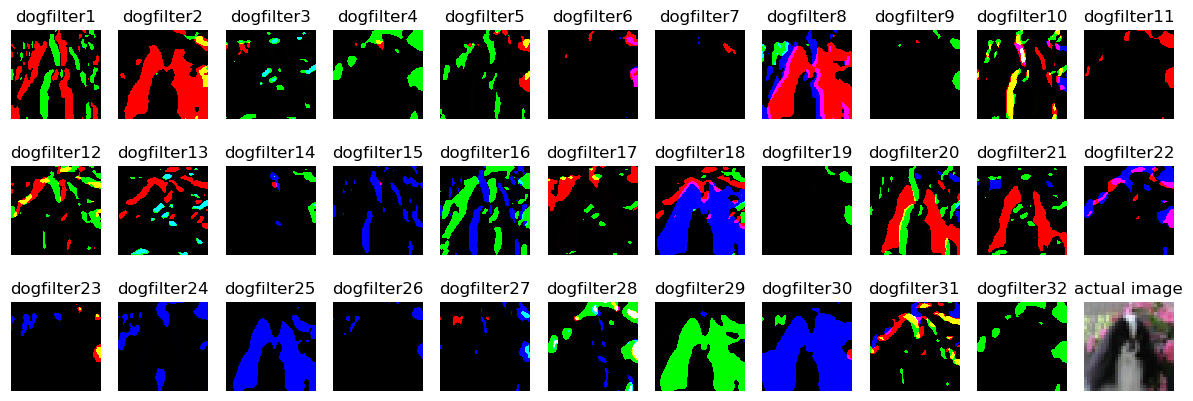

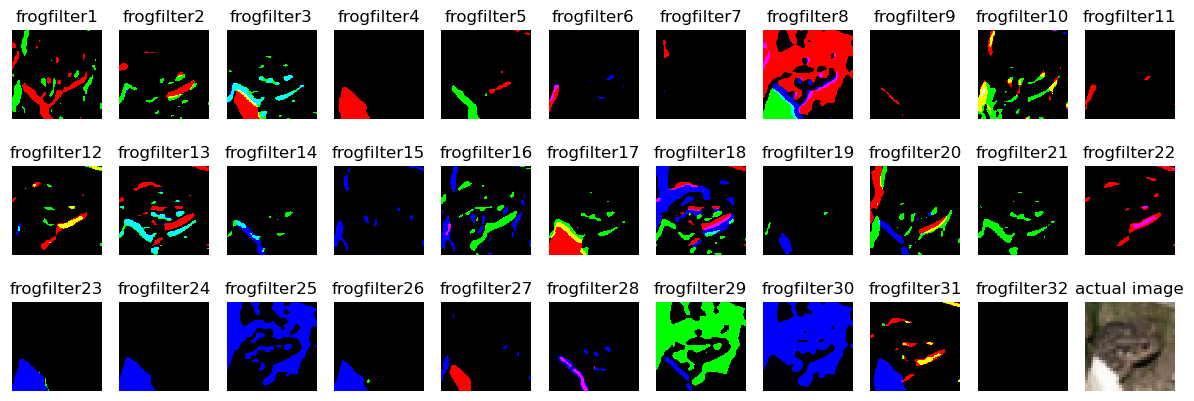

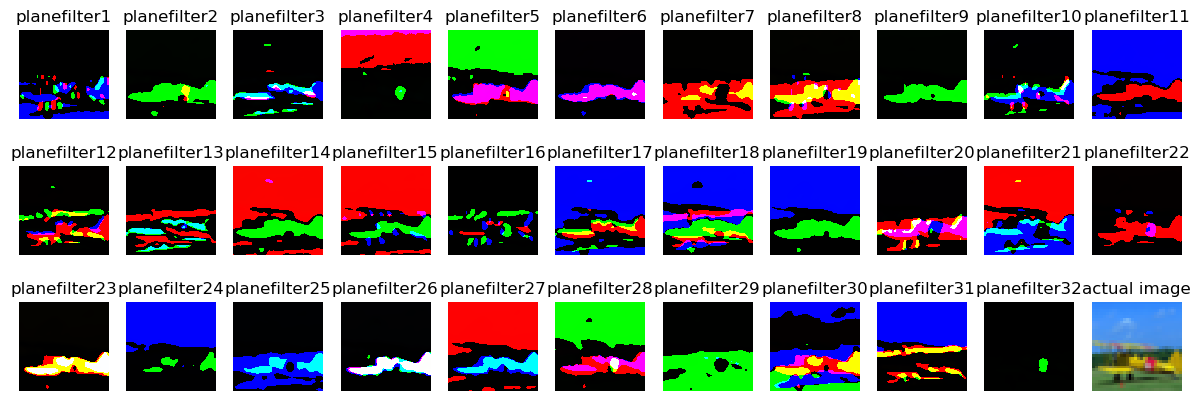

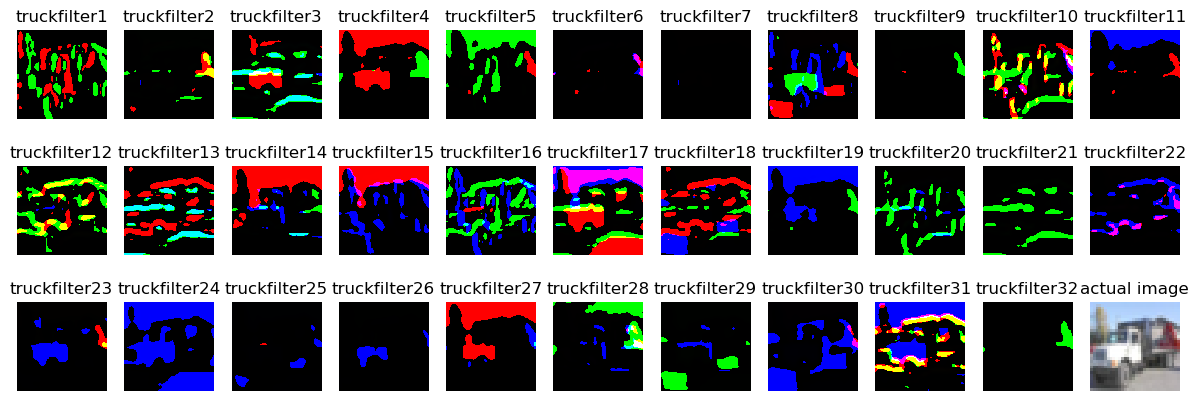

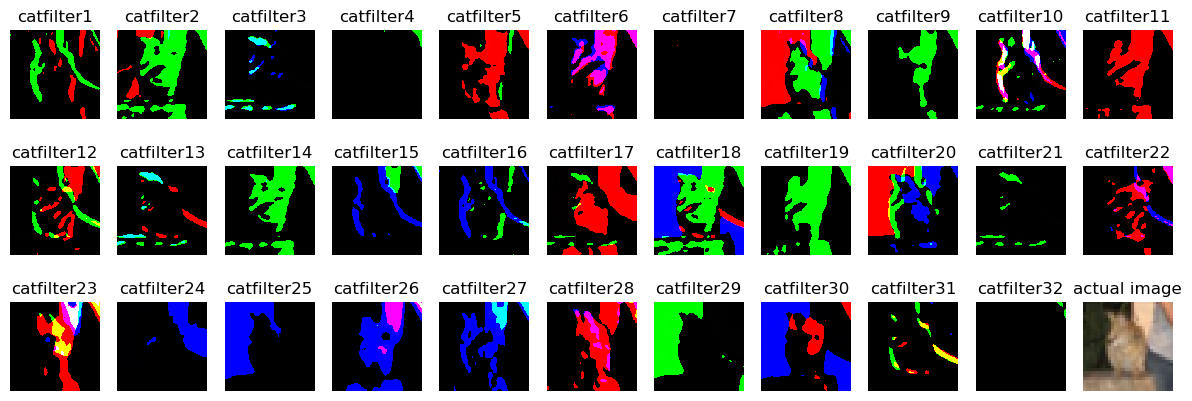

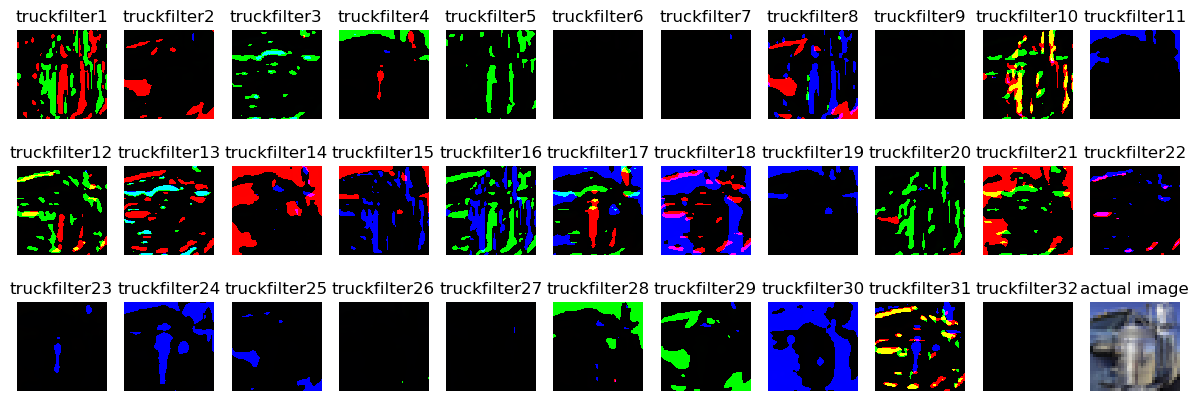

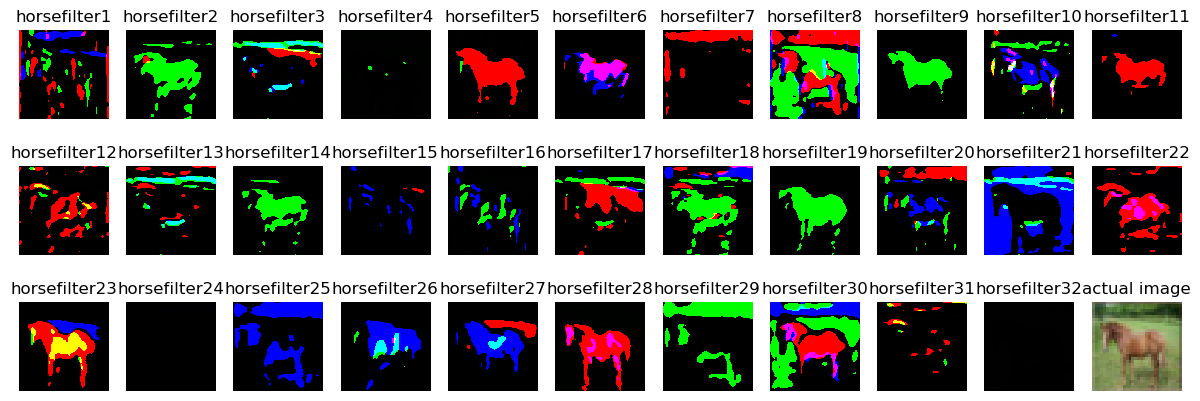

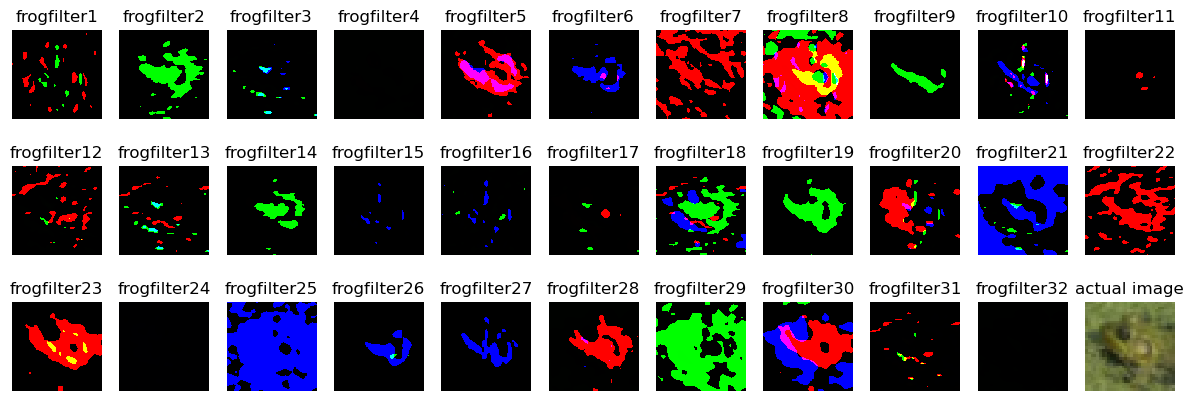

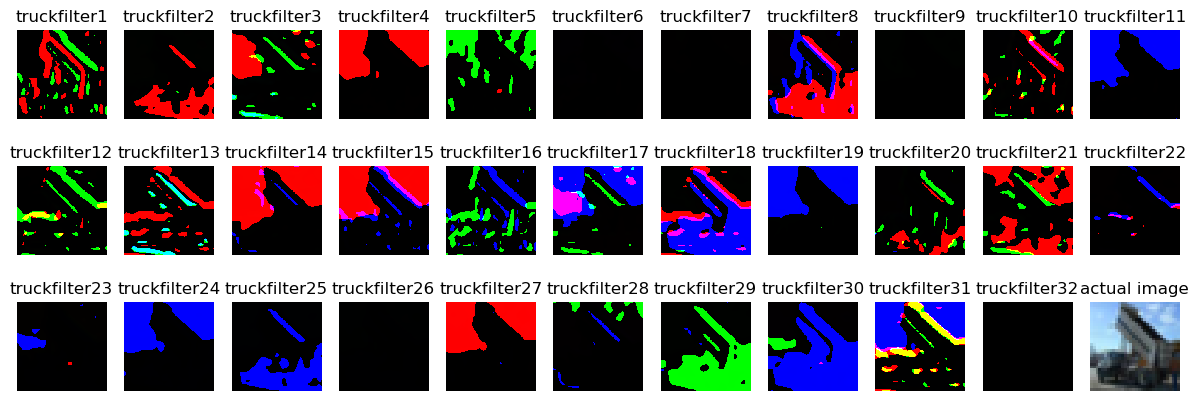

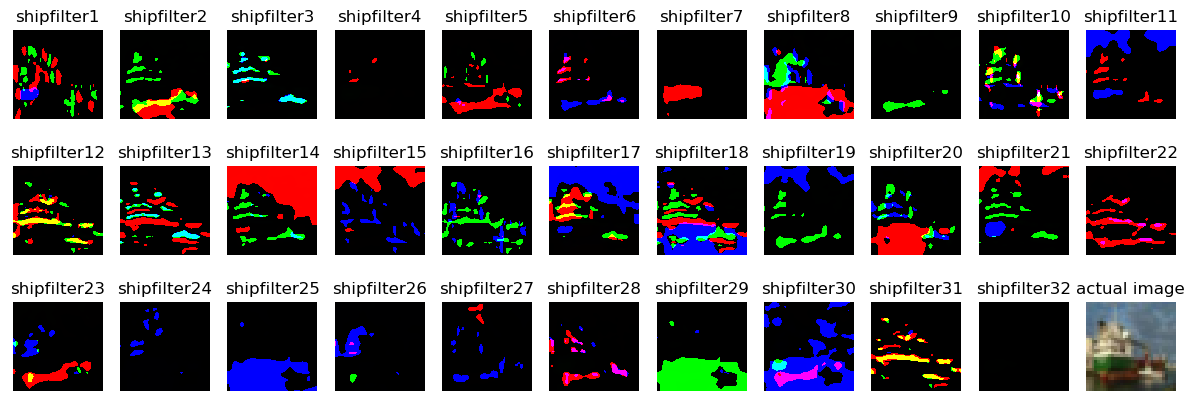

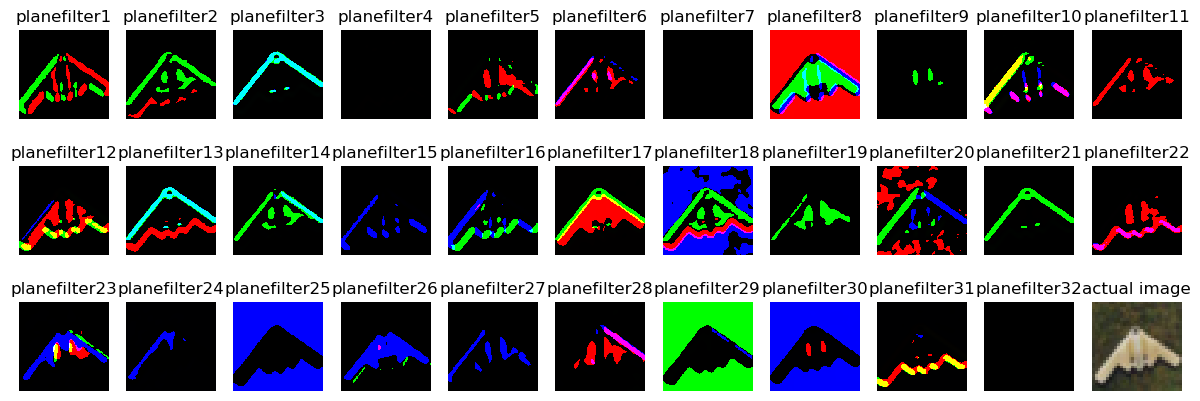

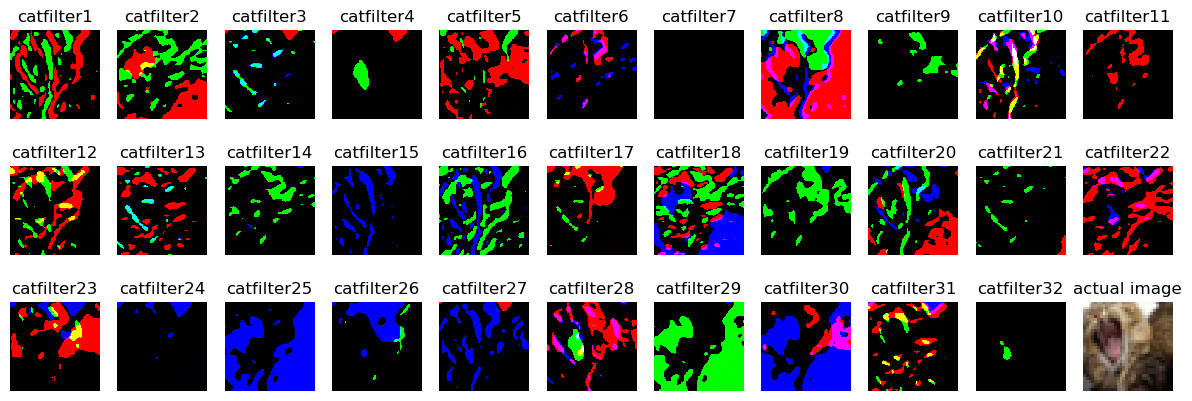

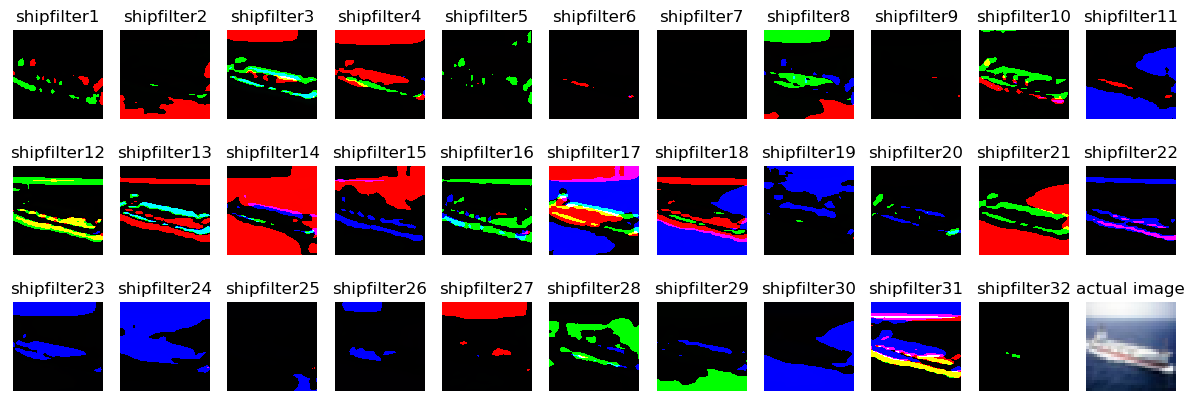

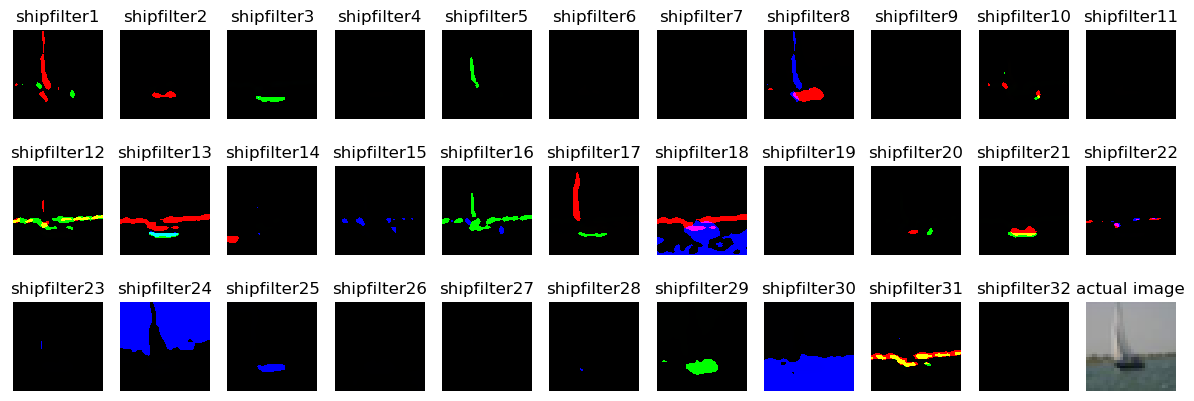

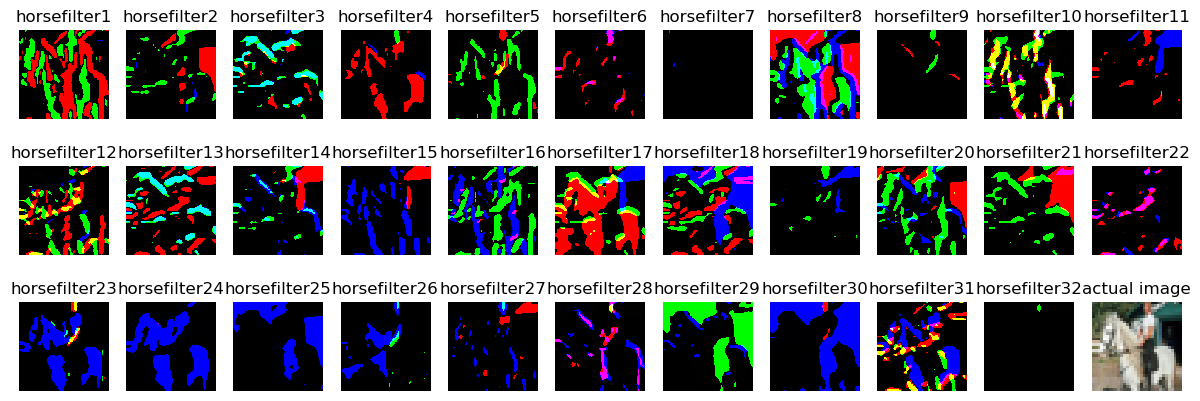

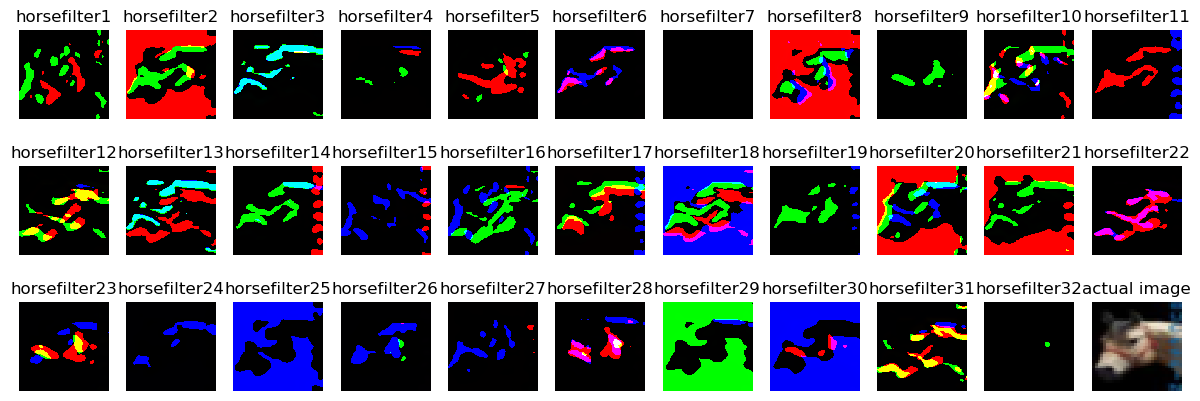

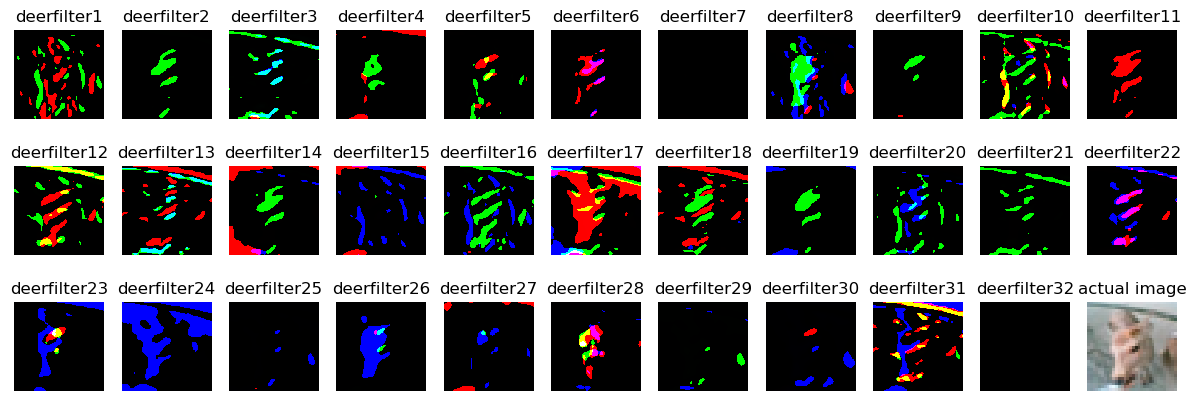

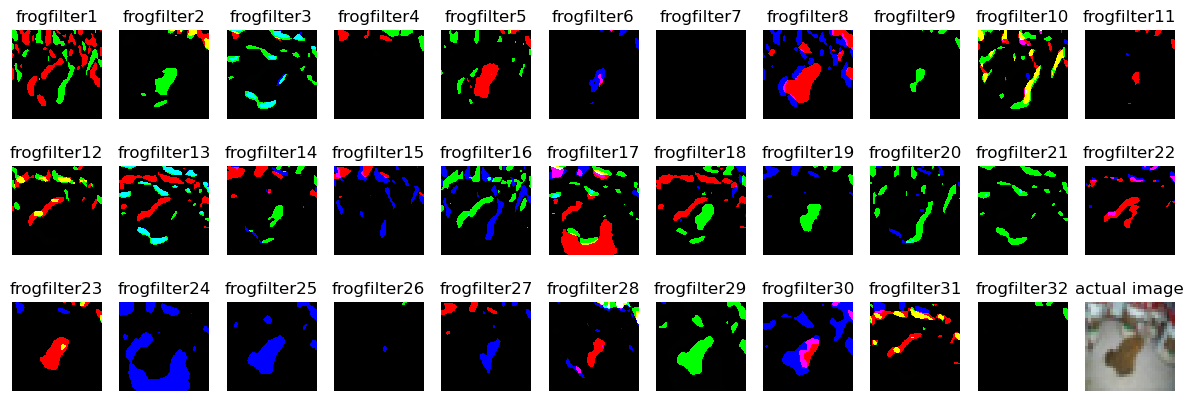

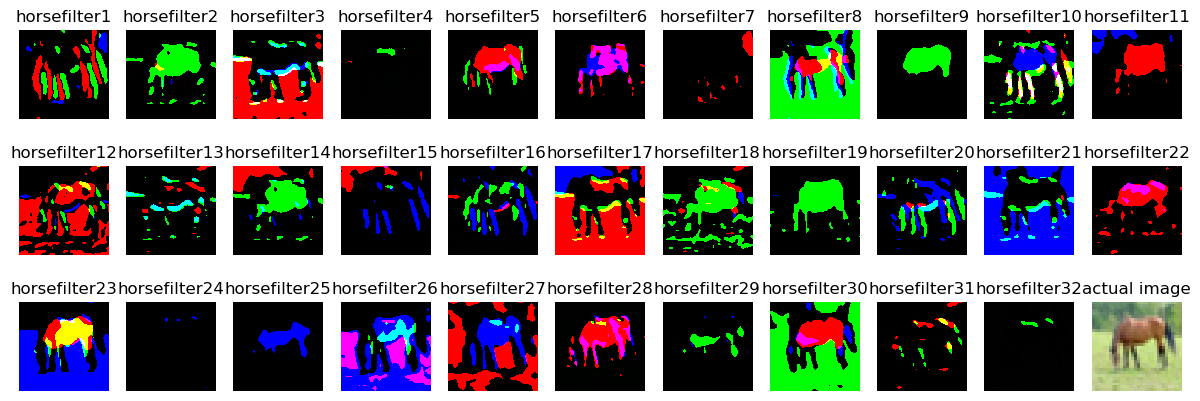

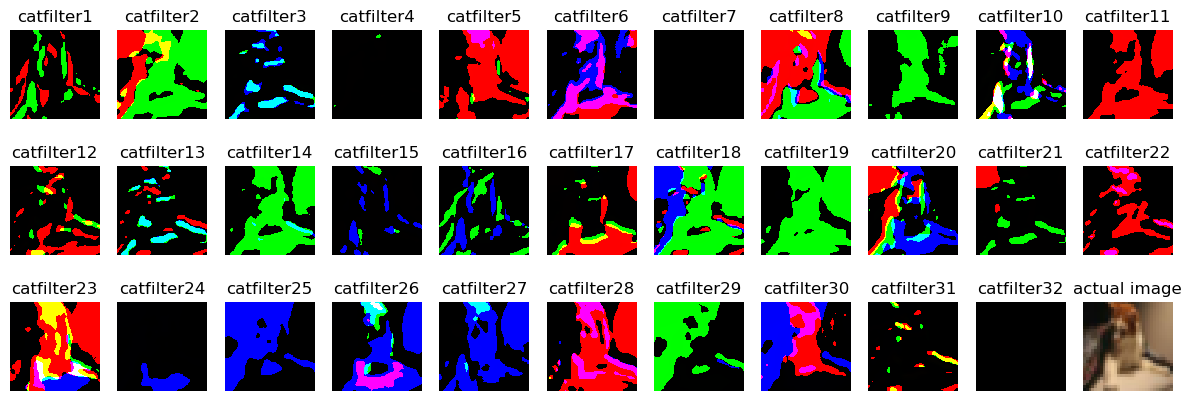

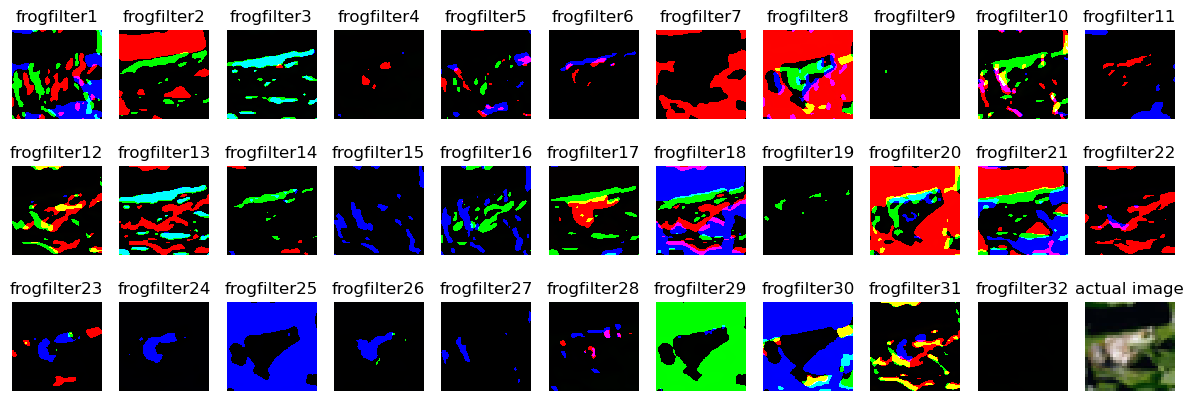

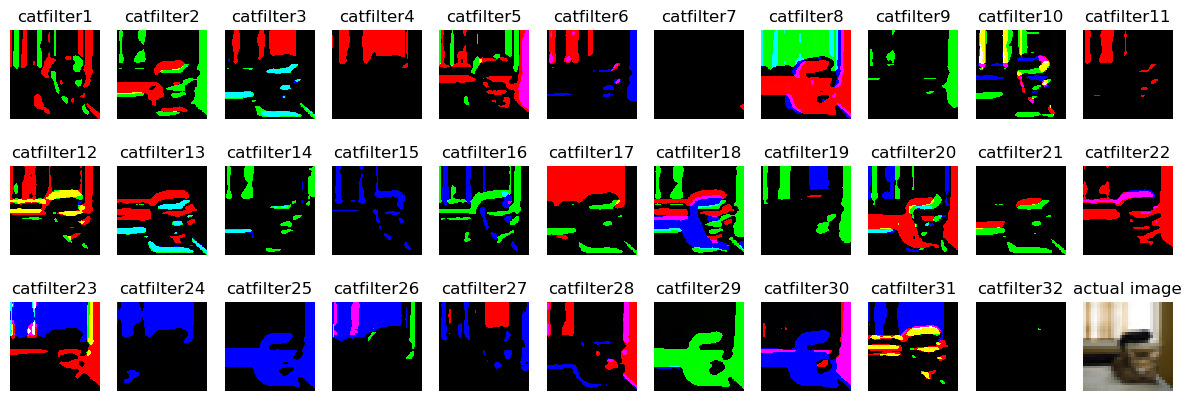

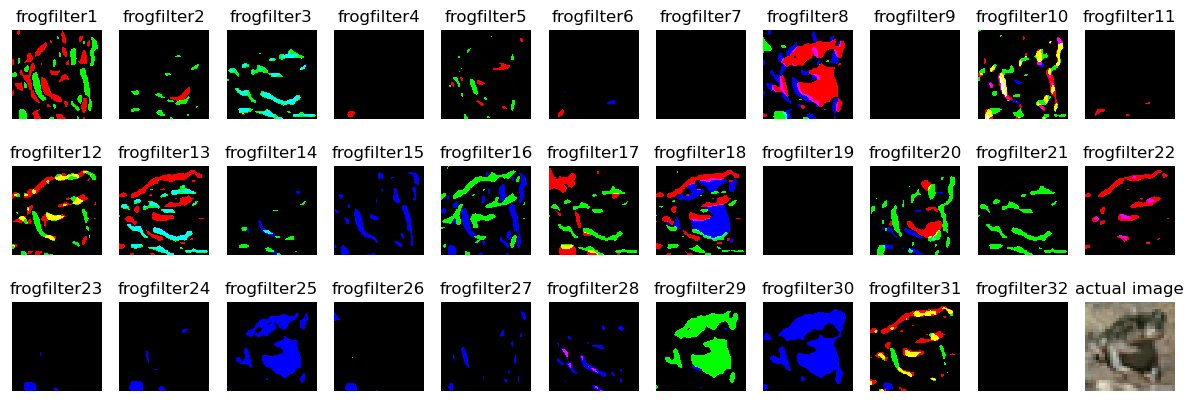

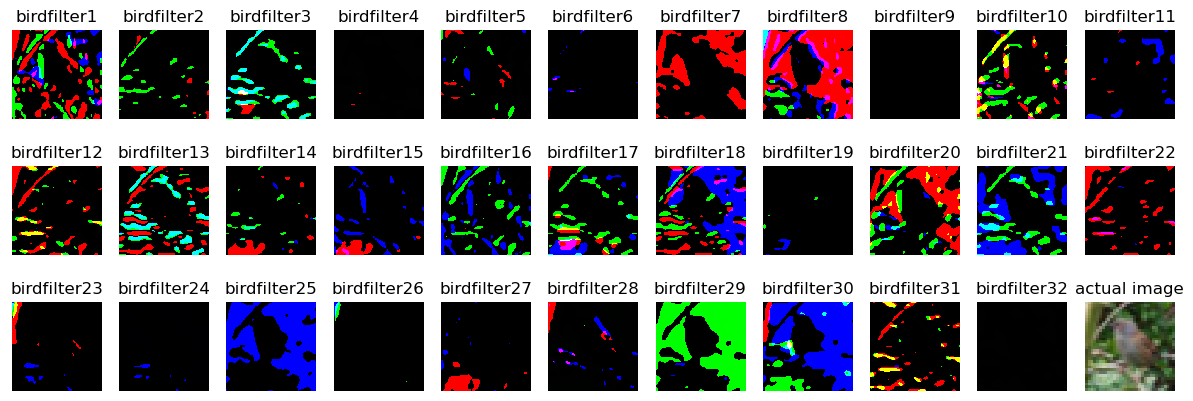

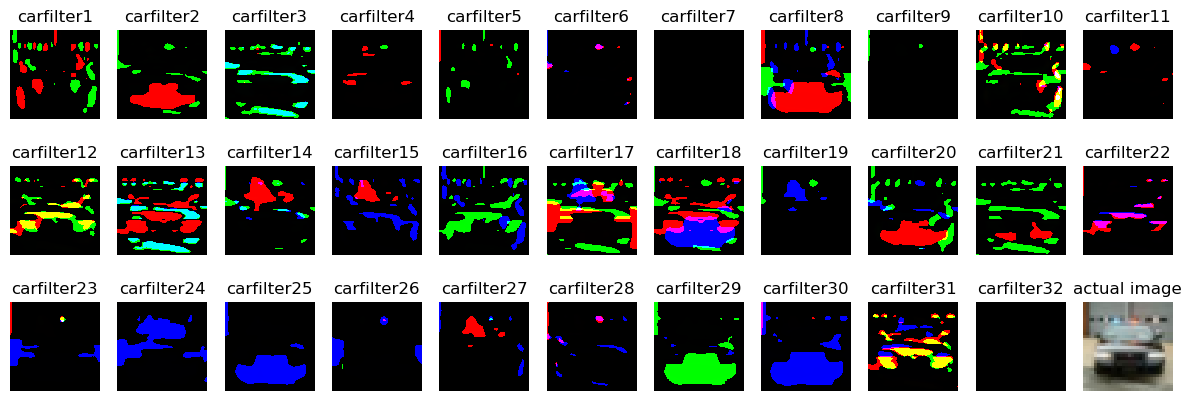

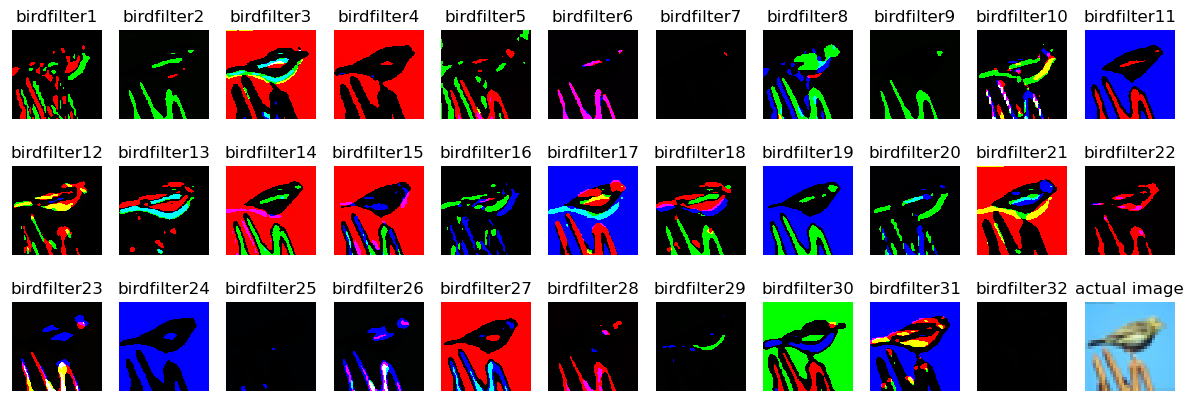

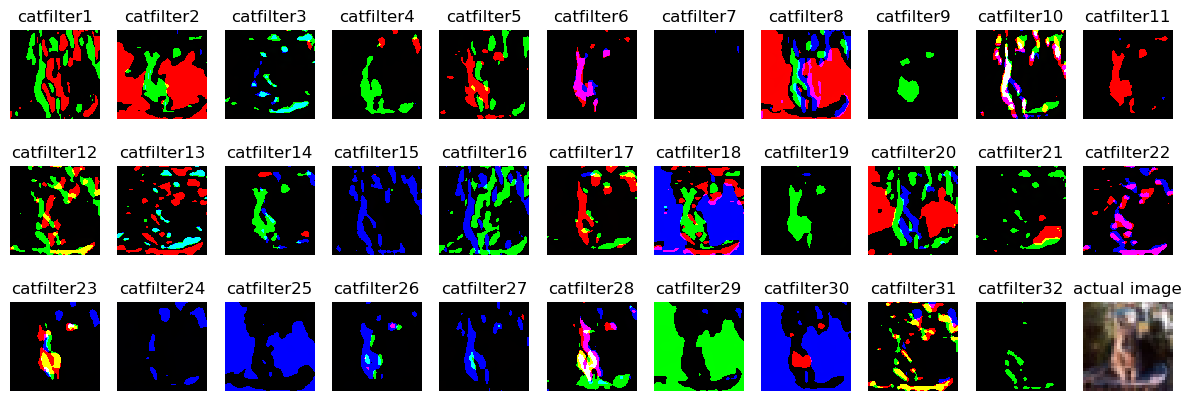

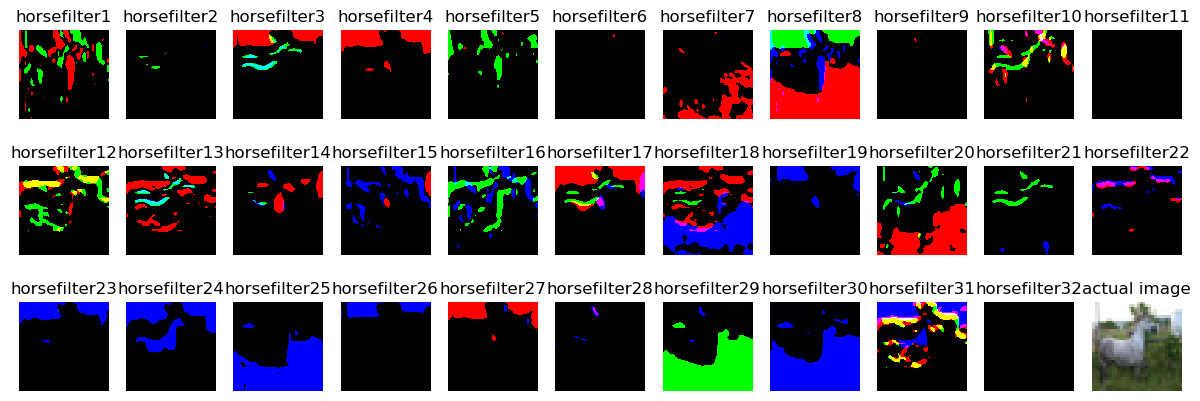

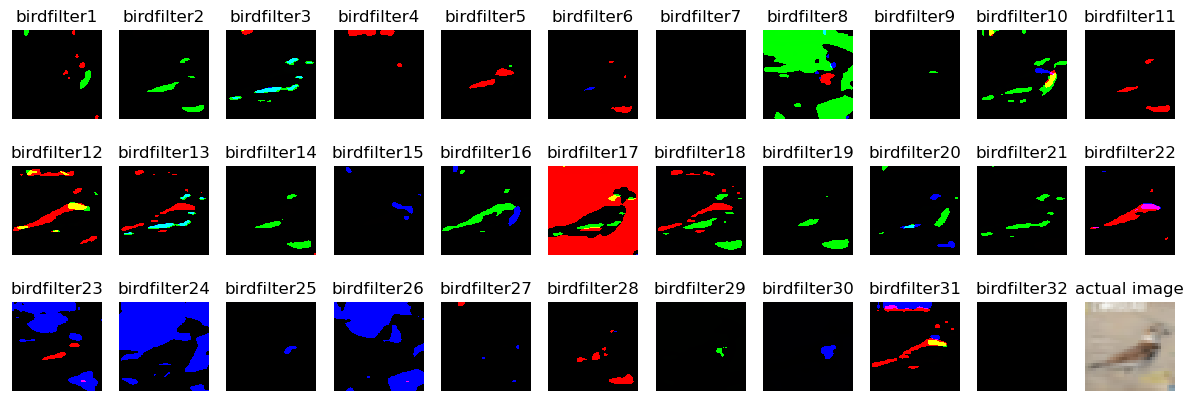

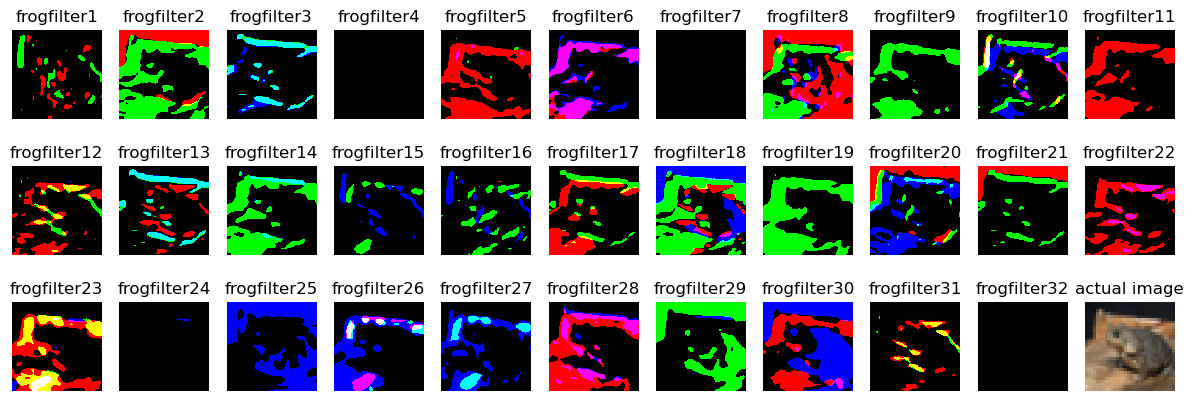

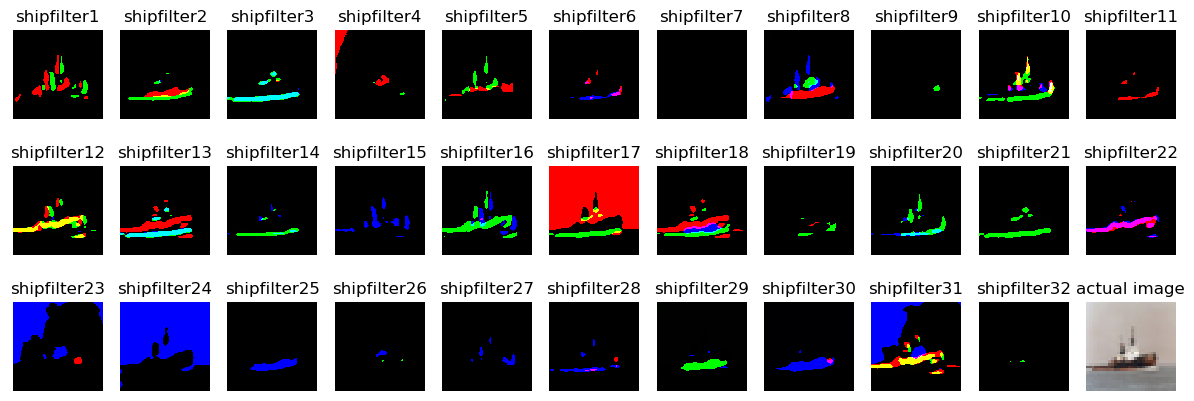

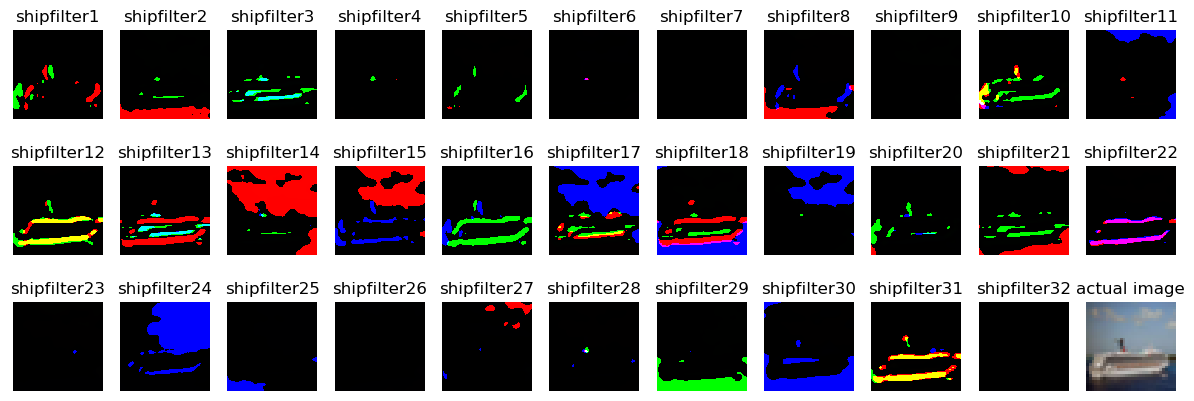

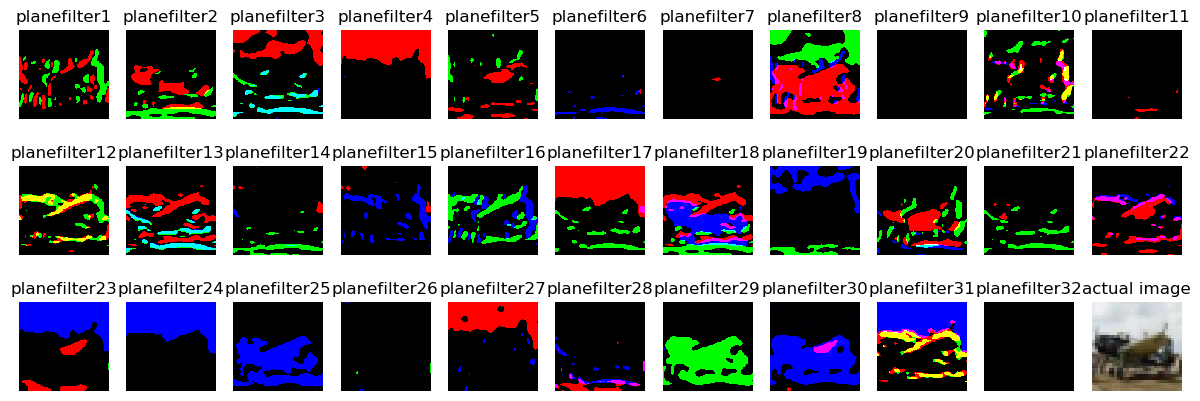

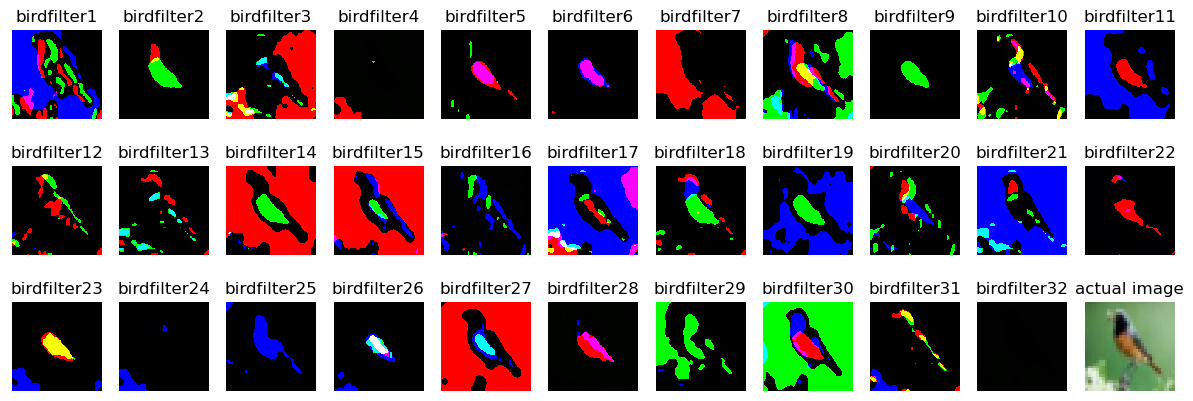

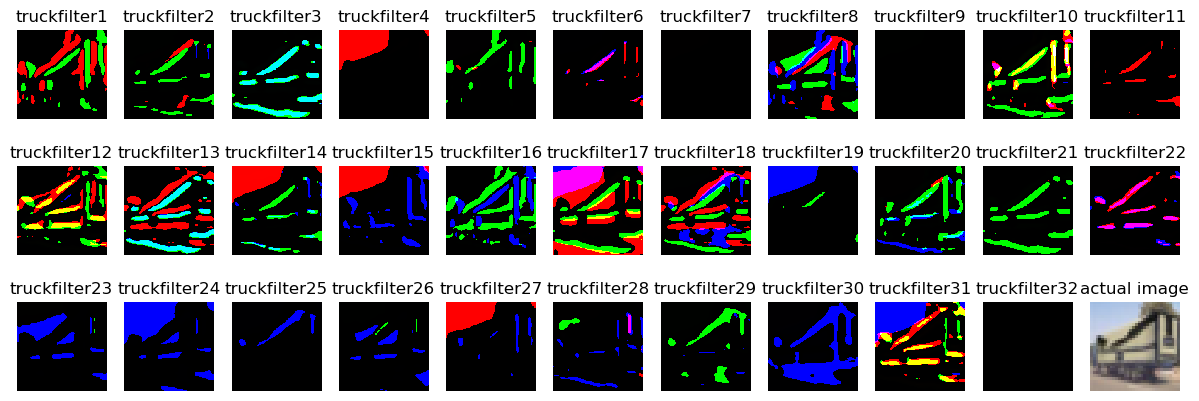

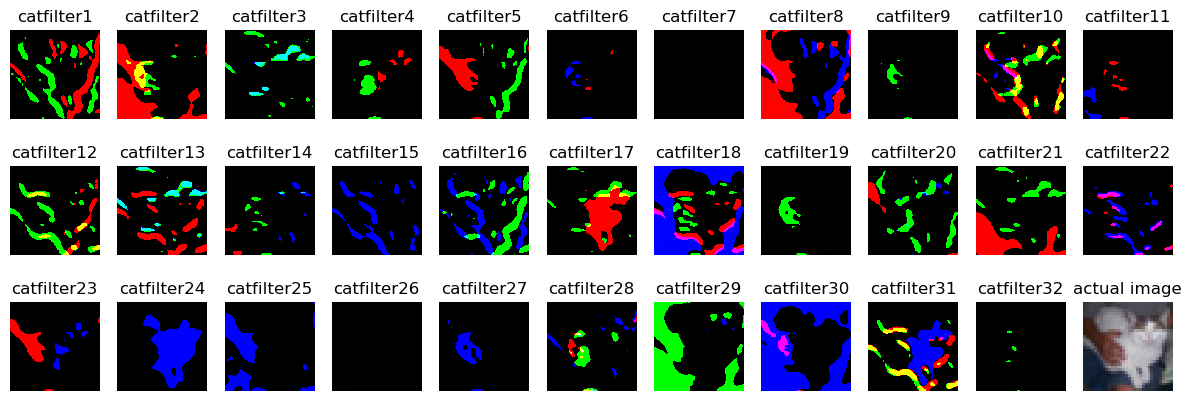

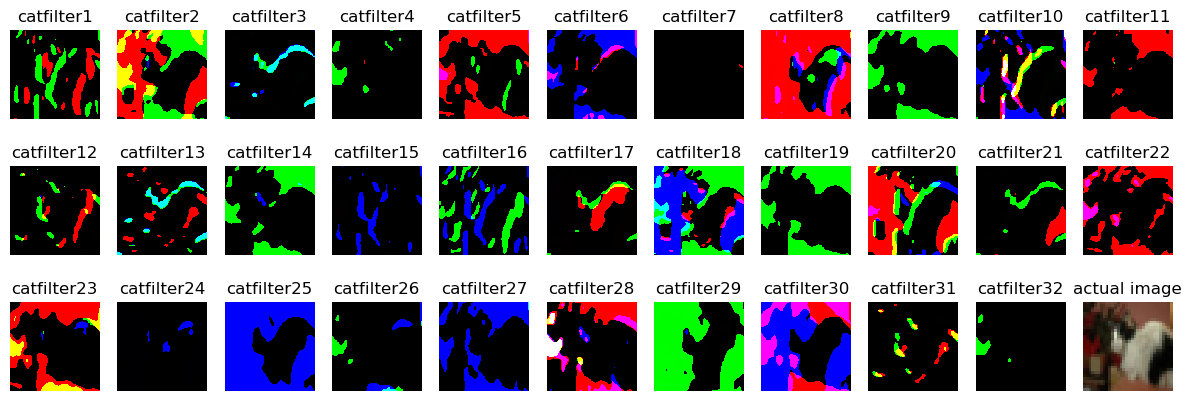

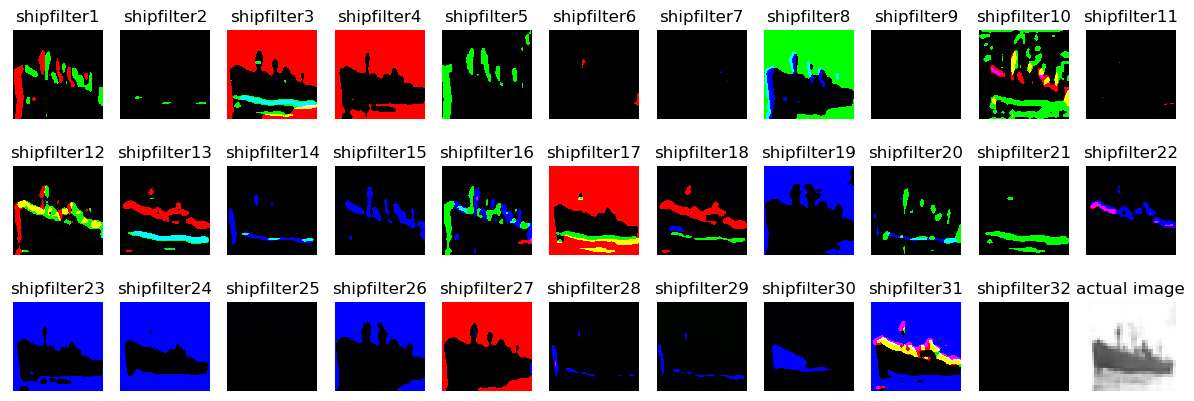

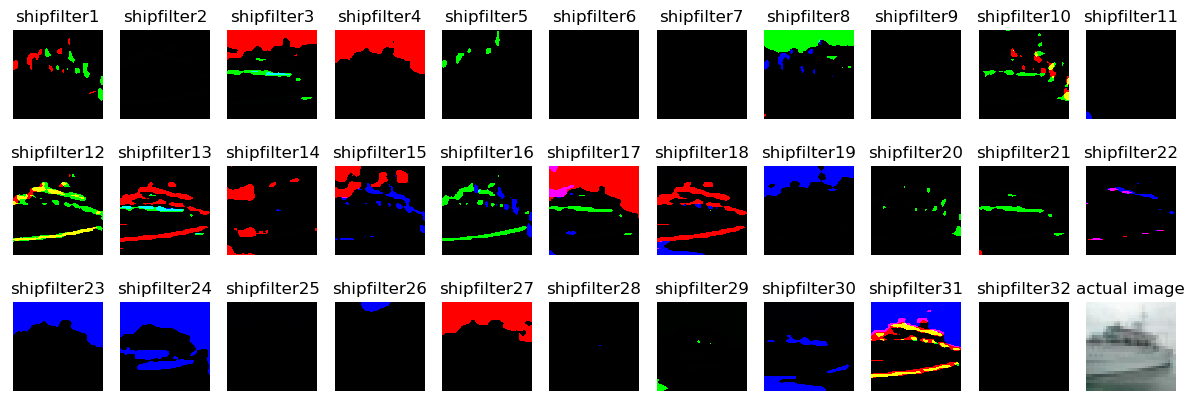

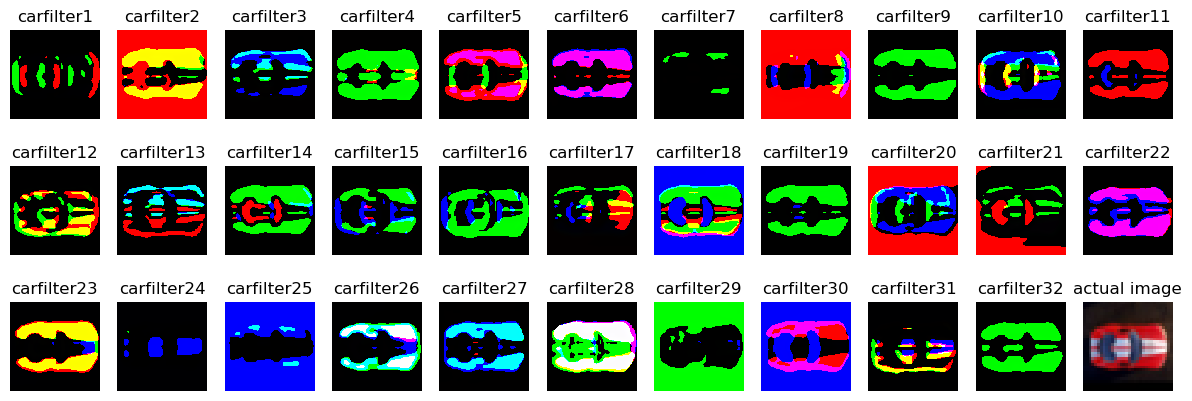

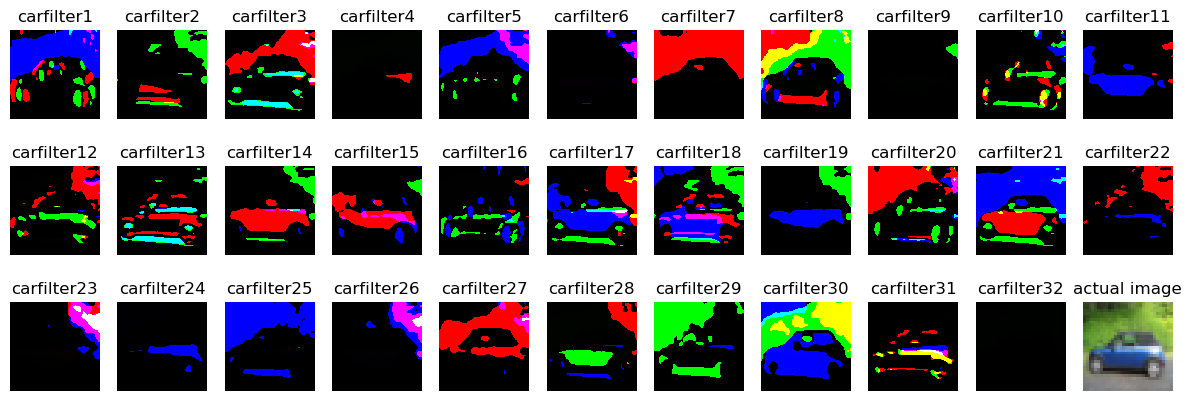

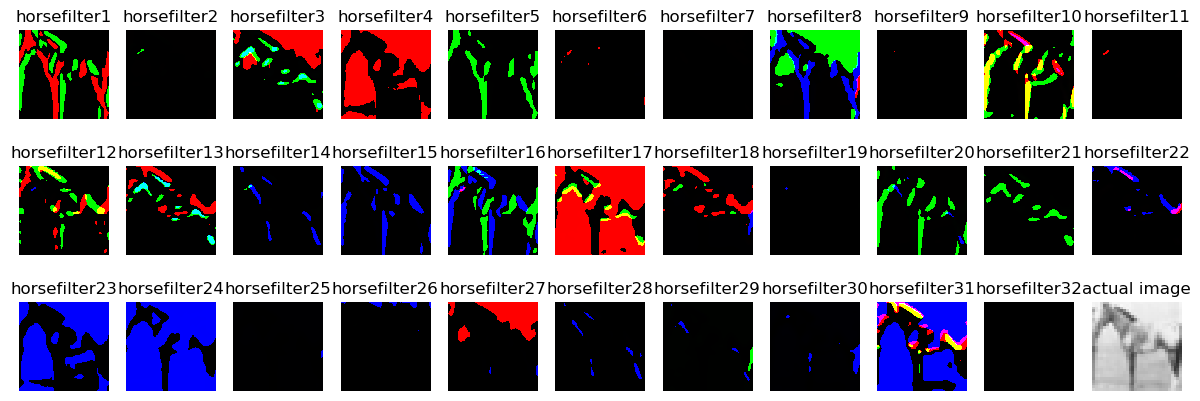

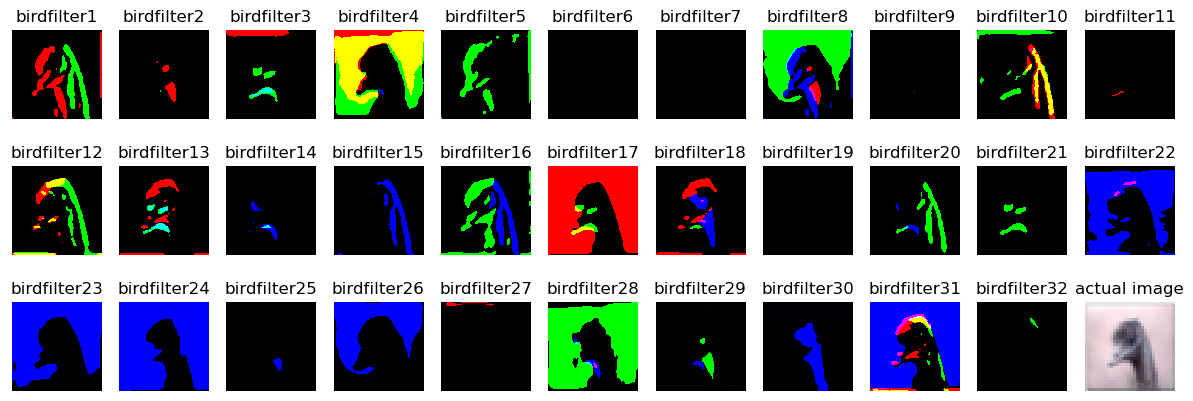

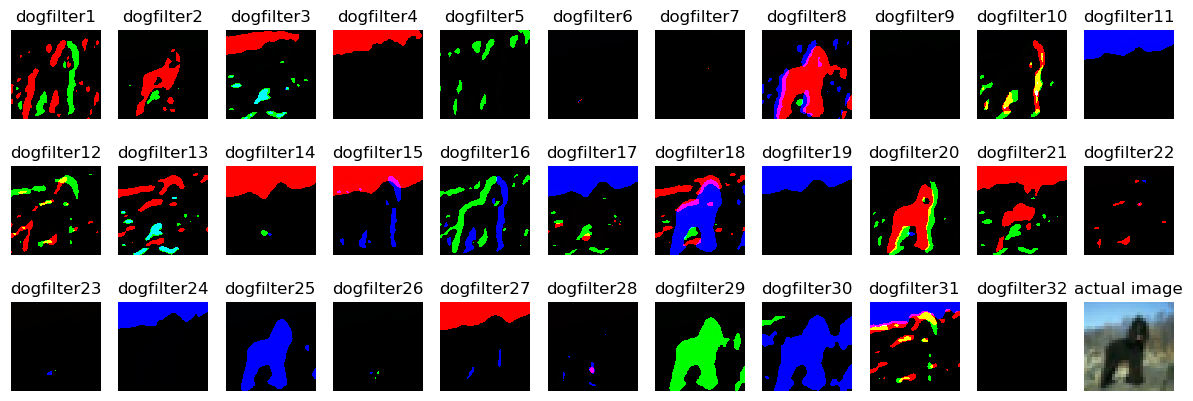

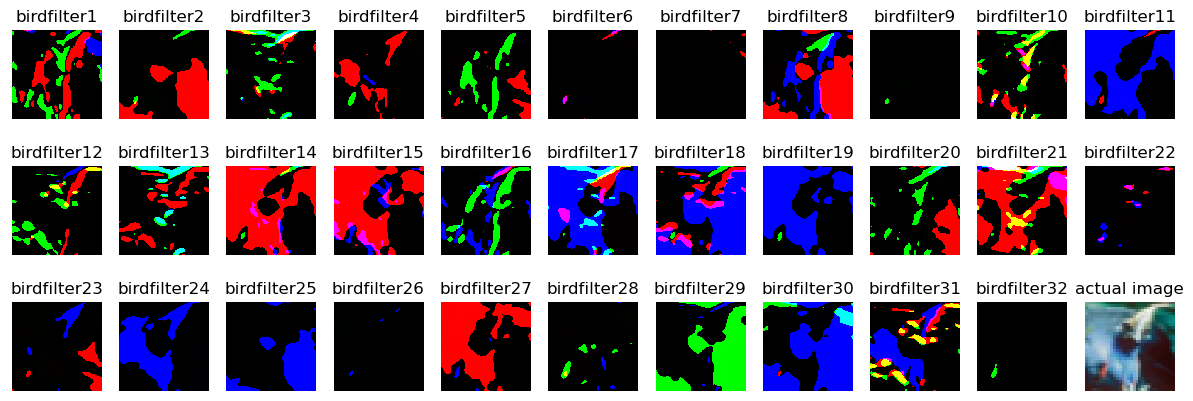

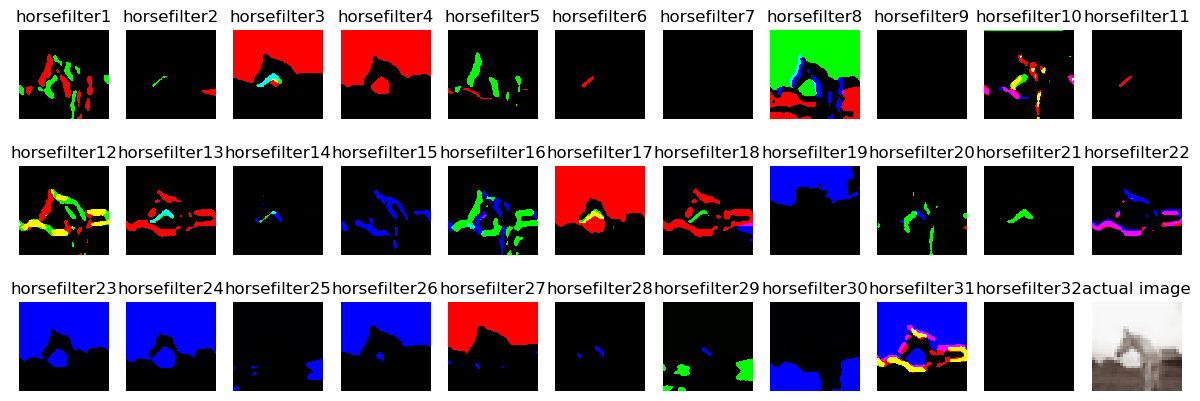

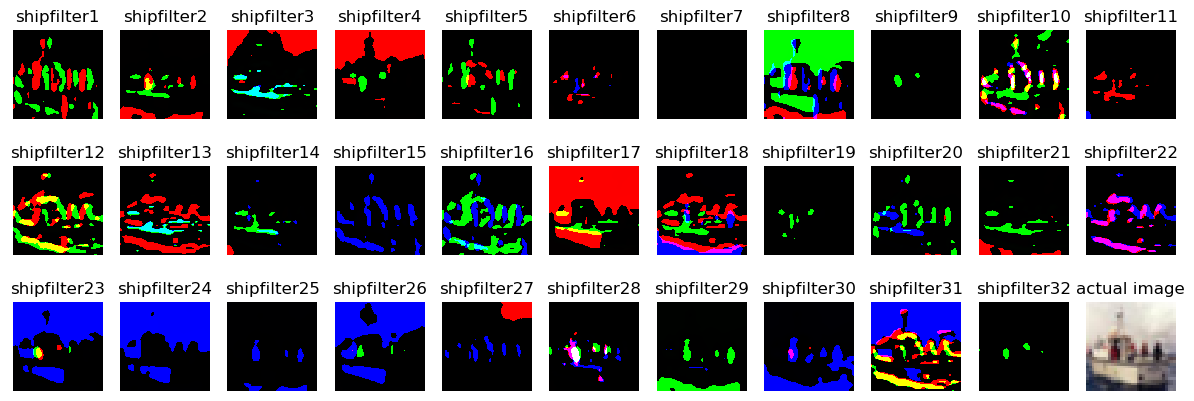

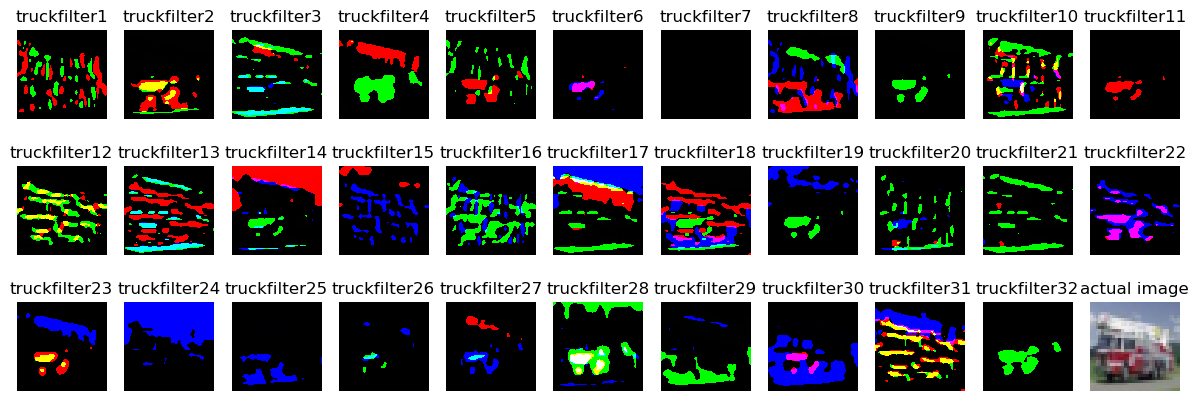

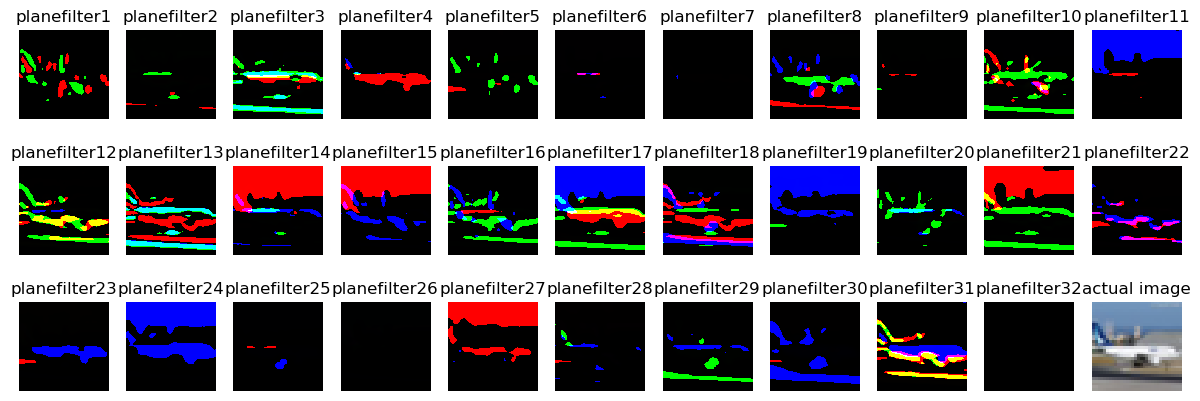

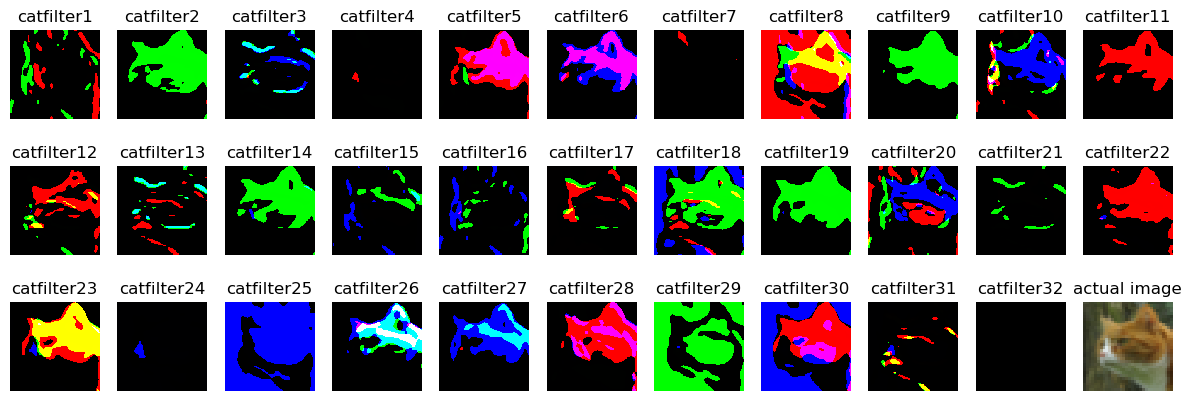

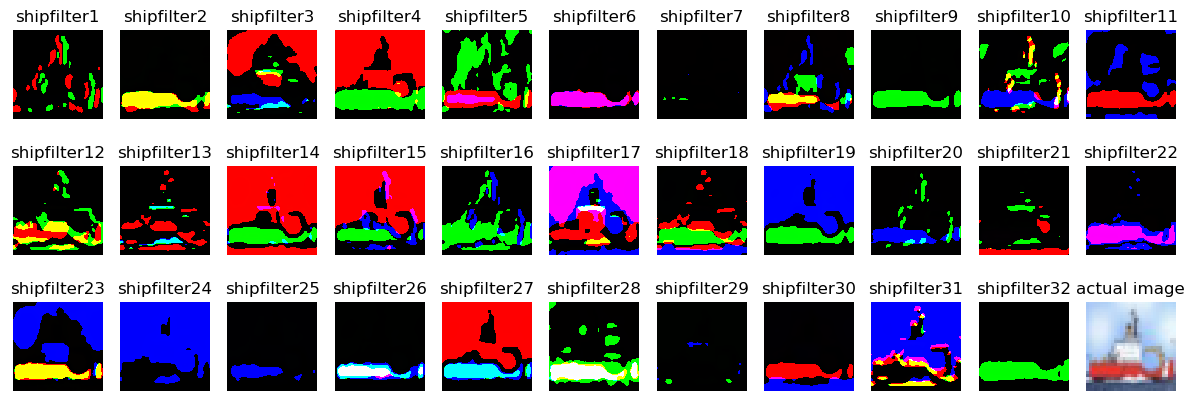

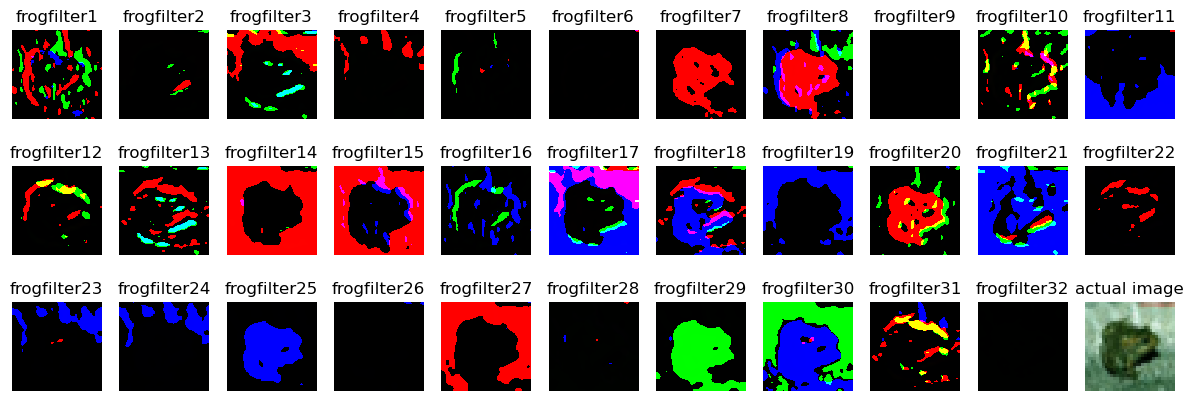

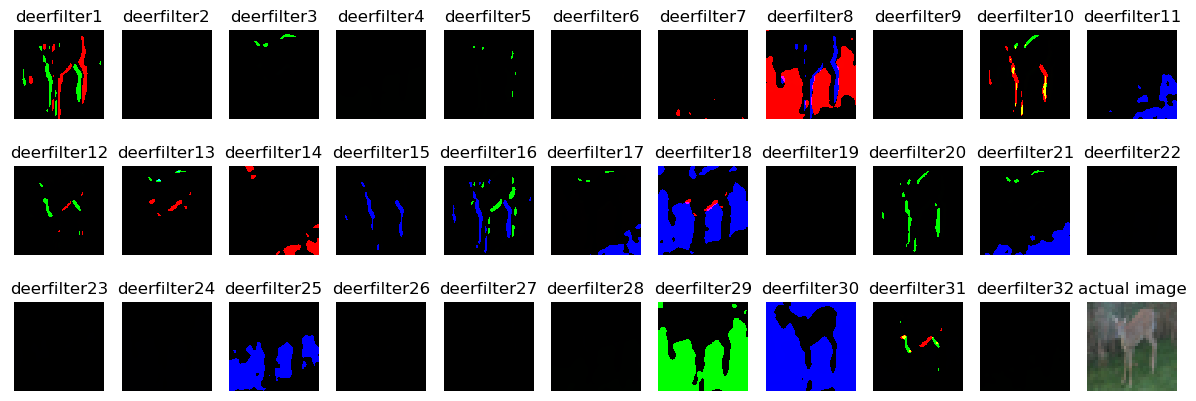

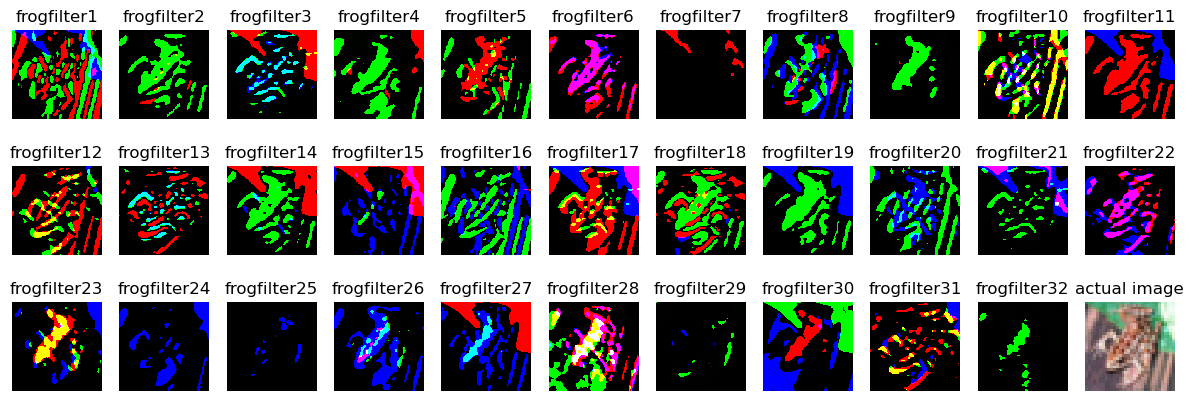

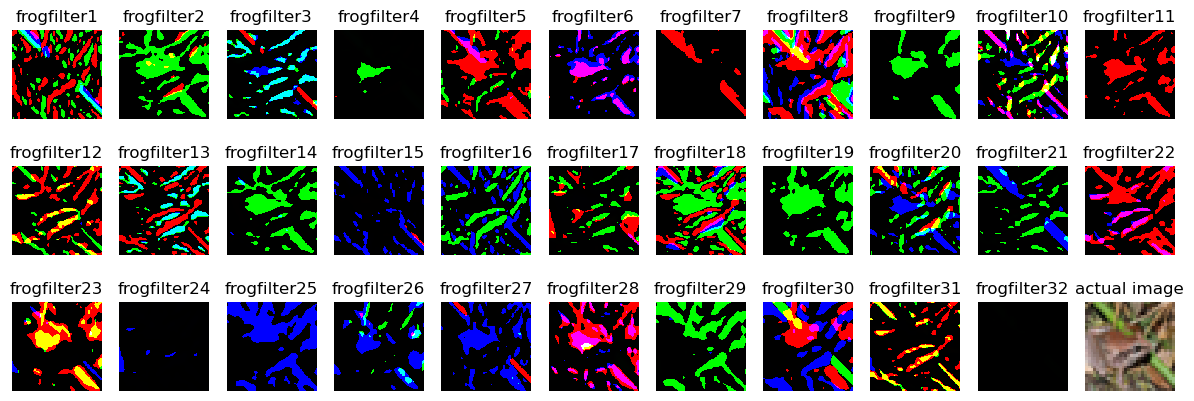

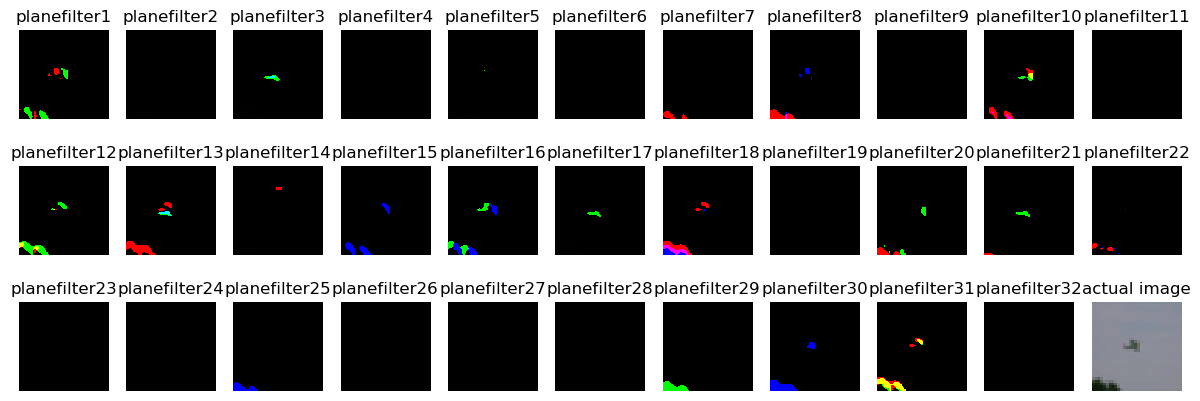

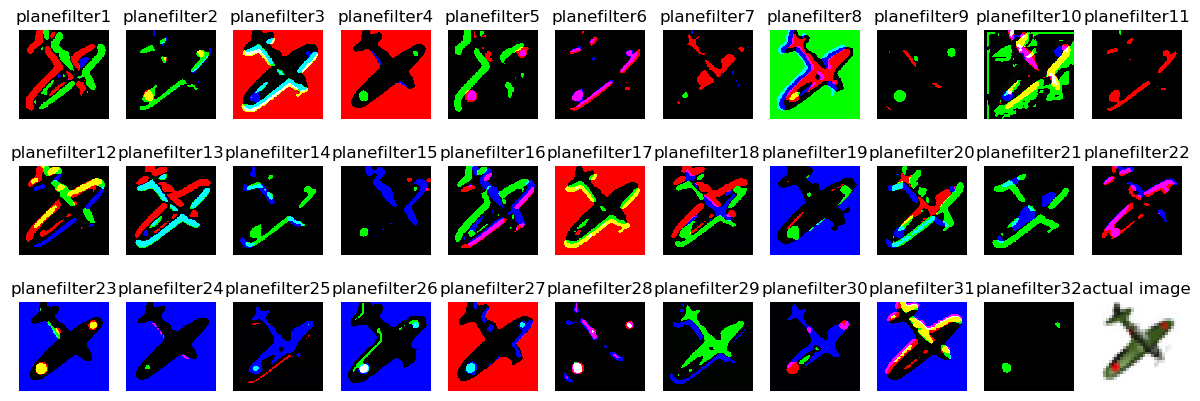

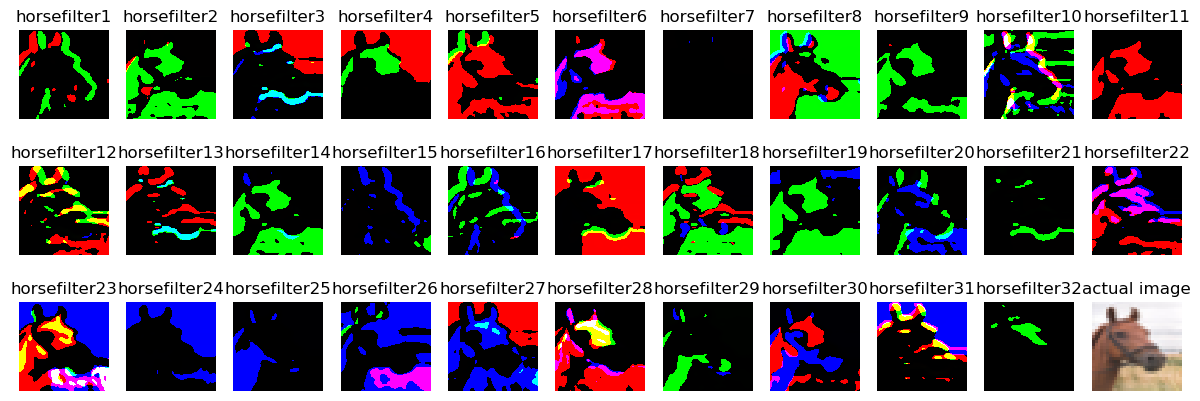

In [12]:
cifar10_test_fun = dset.CIFAR10(root='./datasets',
                                download=True,
                                train=False,
                                transform=T.Compose([T.ToTensor()]))

weight = alexnet.alexnet[0][0].weight.clone()
weight = weight.cpu()
with torch.no_grad():
    for img_idx in range(100):
        trial = cifar10_test[img_idx][0]
        img = F.conv2d(trial, weight)
        img = img.permute(1, 2, 0)

        for i in range(1, 33):
            plt.subplot(3, 11, i)
            plt.imshow(img[:, :, 3*(i-1):3*i].numpy().astype('uint8'))
            plt.axis('off')
            plt.title(classes[cifar10_test[img_idx][1]] + f"filter{i}")
        
        true_img = cifar10_test_fun[img_idx][0].permute(1, 2, 0)
        plt.subplot(3, 11, 33)
        plt.imshow(true_img)
        plt.axis('off')
        plt.title("actual image")
        plt.gcf().set_size_inches(15, 5)
        plt.show()

### I'm also interested in the 96 kernels as shown in the papers, let's have a look.

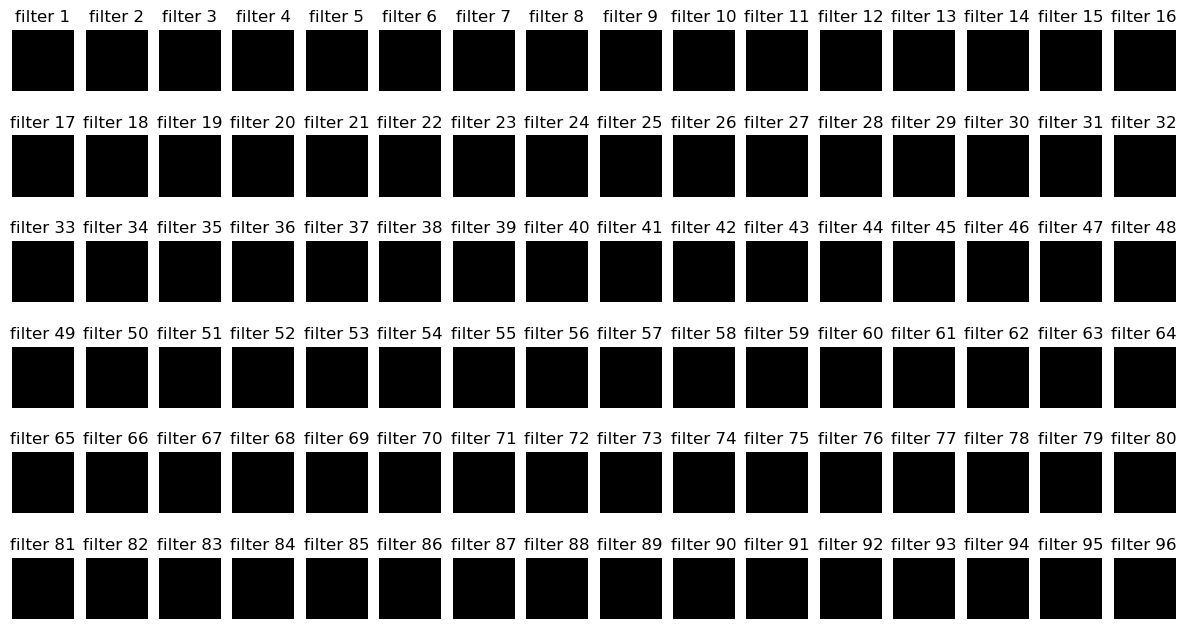

In [15]:
weight_transpose = weight.permute(0, 2, 3, 1)

with torch.no_grad():
    for i in range(weight_transpose.size(0)):
        plt.subplot(6, 16, i+1)
        plt.title(f"filter {i+1}")
        plt.axis('off')
        plt.imshow(weight_transpose[i, :, :, :].numpy().astype('uint8'))
    plt.gcf().set_size_inches(15, 8)
    plt.show()